# Project 76

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
seed = 42
gamma = 0.99
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")
env.seed(seed)
eps = np.finfo(np.float32).eps.item()

In [3]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs, ))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)
model = keras.Model(inputs=inputs, outputs=[action, critic])

In [4]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])
            
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))
            
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward
            
            if done:
                break
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = np.array(returns)
        returns = (returns - np.mean(returns))
        returns = returns.tolist()
        
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            
            diff = ret - value
            actor_losses.append(-log_prob * diff)
            
            critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0)))
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
        
    episode_count += 1
    if episode_count % 10 == 0:
        template = "funning : {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))
    if running_reward > 195:
        print("Solved at episode {}!".format(episode_count))
        break

funning : 9.18 at episode 10
funning : 16.81 at episode 20
funning : 31.87 at episode 30
funning : 35.72 at episode 40
funning : 41.65 at episode 50
funning : 47.75 at episode 60
funning : 34.71 at episode 70
funning : 26.90 at episode 80
funning : 25.56 at episode 90
funning : 24.57 at episode 100
funning : 20.84 at episode 110
funning : 18.20 at episode 120
funning : 17.47 at episode 130
funning : 16.87 at episode 140
funning : 17.82 at episode 150
funning : 18.57 at episode 160
funning : 20.13 at episode 170
funning : 20.41 at episode 180
funning : 25.25 at episode 190
funning : 67.77 at episode 200
funning : 55.01 at episode 210
funning : 87.51 at episode 220
funning : 76.50 at episode 230
funning : 56.61 at episode 240
funning : 46.03 at episode 250
funning : 37.96 at episode 260
funning : 33.73 at episode 270
funning : 30.70 at episode 280
funning : 30.29 at episode 290
funning : 30.23 at episode 300
funning : 31.10 at episode 310
funning : 31.73 at episode 320
funning : 36.89 at

# Project 77

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [4]:
problem = "Pendulum-v1"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space -> {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space -> {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action -> {}".format(upper_bound))
print("Min Value of Action -> {}".format(lower_bound))

Size of State Space -> 3
Size of Action Space -> 1
Max Value of Action -> 2.0
Min Value of Action -> -2.0


In [16]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    def __call__(self):
        x = (self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt + self.std_dev * np.sqrt(self.dt) * 
            np.random.normal(size=self.mean.shape))
        self.x_prev = x
        return x
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [17]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = tf.math.reduce_mean(critic_value)
            
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))
    def learn(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        self.update(state_batch, action_batch, reward_batch, next_state_batch)

@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [18]:
def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)
    
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    
    concat = layers.Concatenate()([state_out, action_out])
    
    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

In [19]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

In [20]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
actor_model = get_actor()
critic_model = get_critic()
target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
gamma = 0.99
tau = 0.005
buffer = Buffer(50000, 64)

In [21]:
ep_reward_list = []
avg_reward_list = []
for ep in range(total_episodes):
    prev_state = env.reset()
    episodic_reward = 0
    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        state, reward, done, info = env.step(action)
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        if done:
            break
        prev_state = state
    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

Episode * 0 * Avg Reward is ==> -1534.7439129876966
Episode * 1 * Avg Reward is ==> -1580.6970575050454
Episode * 2 * Avg Reward is ==> -1583.633588333866
Episode * 3 * Avg Reward is ==> -1443.2006476177376
Episode * 4 * Avg Reward is ==> -1298.3092457293158
Episode * 5 * Avg Reward is ==> -1330.6386139729832
Episode * 6 * Avg Reward is ==> -1293.868790017301
Episode * 7 * Avg Reward is ==> -1319.7257953368803
Episode * 8 * Avg Reward is ==> -1287.465270097594
Episode * 9 * Avg Reward is ==> -1317.662869566954
Episode * 10 * Avg Reward is ==> -1274.7596962234072
Episode * 11 * Avg Reward is ==> -1308.561974031937
Episode * 12 * Avg Reward is ==> -1318.576771601774
Episode * 13 * Avg Reward is ==> -1343.9033919397505
Episode * 14 * Avg Reward is ==> -1364.7626127493702
Episode * 15 * Avg Reward is ==> -1381.8526967496605
Episode * 16 * Avg Reward is ==> -1405.8412461253652
Episode * 17 * Avg Reward is ==> -1426.0412509191208
Episode * 18 * Avg Reward is ==> -1436.3209571419302
Episode *

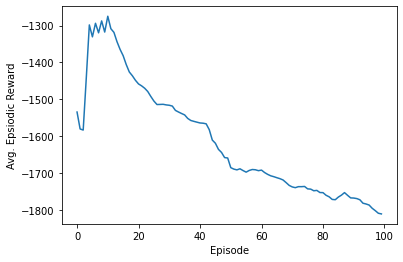

In [22]:
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

# Project 78

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import scipy.signal
import time

In [25]:
def discounted_cumulative_sums(x, discount):
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

class Buffer:
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        self.observation_buffer = np.zeros((size, observation_dimensions), dtype=np.float32)
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0
    
    def store(self, observation, action, reward, value, logprobability):
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1
    
    def finish_trajectory(self, last_value=0):
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)
        
        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]
        
        self.advantage_buffer[path_slice] = discounted_cumulative_sums(deltas, self.gamma * self.lam)
        self.return_buffer[path_slice] = discounted_cumulative_sums(rewards, self.gamma)[:-1]
        self.trajectory_start_index = self.pointer
        
    def get(self):
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (np.mean(self.advantage_buffer), np.std(self.advantage_buffer))
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (self.observation_buffer, self.action_buffer, self.advantage_buffer, self.return_buffer, 
               self.logprobability_buffer)

def mlp(x, sizes, activation=tf.tanh, output_activation=None):
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)

def logprobabilities(logits, a):
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(tf.one_hot(a, num_actions) * logprobabilities_all, axis=1)
    return logprobability

@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    return logits, action

@tf.function
def train_policy(observation_buffer, action_buffer, logprobability_buffer, advantage_buffer):
    with tf.GradientTape() as tape:
        ratio = tf.exp(logprobabilities(actor(observation_buffer), action_buffer) - logprobability_buffer)
        min_advantage = tf.where(advantage_buffer > 0, (1 + clip_ratio) * advantage_buffer, 
                                 (1 - clip_ratio) * advantage_buffer)
        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantage_buffer, min_advantage))
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))
    
    kl = tf.reduce_mean(logprobability_buffer - logprobabilities(actor(observation_buffer), action_buffer))
    kl = tf.reduce_sum(kl)
    return kl

@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [26]:
steps_per_epoch = 4000
epochs = 30
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iteration = 80
train_value_iteration = 80
lam = 0.97
target_kl = 0.01
hidden_sizes = (64, 64)

render = False

In [27]:
env = gym.make("CartPole-v0")
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.n

buffer = Buffer(observation_dimensions, steps_per_epoch)

observation_input = keras.Input(shape=(observation_dimensions, ), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.tanh, None)
actor = keras.Model(inputs = observation_input, outputs=logits)
value = tf.squeeze(mlp(observation_input, list(hidden_sizes) + [1], tf.tanh, None), axis=1)
critic = keras.Model(inputs=observation_input, outputs=value)

policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

observation, episode_return, episode_length = env.reset(), 0, 0

In [28]:
for epoch in range(epochs):
    sum_return = 0
    sum_length = 0
    num_episodes = 0
    
    for t in range(steps_per_epoch):
        if render:
            env.render()
        observation = observation.reshape(1, -1)
        logits, action = sample_action(observation)
        observation_new, reward, done, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1
        
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)
        
        buffer.store(observation, action, reward, value_t, logprobability_t)
        
        observation = observation_new
        
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, episode_return, episode_length = env.reset(), 0, 0
    (observation_buffer, action_buffer, advantage_buffer, return_buffer, logprobability_buffer) = buffer.get()
    for _ in range(train_policy_iteration):
        kl = train_policy(observation_buffer, action_buffer, logprobability_buffer, advantage_buffer)
        if kl > 1.5 * target_kl:
            break
    for _ in range(train_value_iteration):
        train_value_function(observation_buffer, return_buffer)
    print(f"Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}. Mean Length: {sum_length/num_episodes}")

Epoch: 1. Mean Return: 32.0. Mean Length: 32.0
Epoch: 2. Mean Return: 47.61904761904762. Mean Length: 47.61904761904762
Epoch: 3. Mean Return: 53.333333333333336. Mean Length: 53.333333333333336
Epoch: 4. Mean Return: 90.9090909090909. Mean Length: 90.9090909090909
Epoch: 5. Mean Return: 100.0. Mean Length: 100.0
Epoch: 6. Mean Return: 148.14814814814815. Mean Length: 148.14814814814815
Epoch: 7. Mean Return: 133.33333333333334. Mean Length: 133.33333333333334
Epoch: 8. Mean Return: 173.91304347826087. Mean Length: 173.91304347826087
Epoch: 9. Mean Return: 173.91304347826087. Mean Length: 173.91304347826087
Epoch: 10. Mean Return: 181.8181818181818. Mean Length: 181.8181818181818
Epoch: 11. Mean Return: 190.47619047619048. Mean Length: 190.47619047619048
Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
Epoch: 13. Mean Return: 190.47619047619048. Mean Length: 190.47619047619048
Epoch: 14. Mean Return: 190.47619047619048. Mean Length: 190.47619047619048
Epoch: 15. Mean Return: 200.0. Me

# Project 79

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os

In [2]:
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

In [3]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

print(citations)

print(papers)


180224/168052 [================================] - 2s 8us/step
      target  source
0          0      21
1          0     905
2          0     906
...      ...     ...
5426    1874    2586
5427    1876    1874
5428    1897    2707

[5429 rows x 2 columns]
      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
0          462       0       0  ...          0          0        2
1         1911       0       0  ...          0          0        5
2         2002       0       0  ...          0          0        4
...        ...     ...     ...  ...        ...        ...      ...
2705      2372       0       0  ...          0          0        1
2706       955       0       0  ...          0          0        0
2707       376       0       0  ...          0          0        2

[2708 rows x 1435 columns]


In [5]:
random_indices = np.random.permutation(range(papers.shape[0]))
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2:]]

In [7]:
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()

train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()

edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(papers.sort_values("paper_id").iloc[:, 1:-1])
print("Edges shape: \t\t", edges.shape)
print("Node features shape:", node_states.shape)

Edges shape: 		 (5429, 2)
Node features shape: (2708, 1433)


In [20]:
class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):

        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linearly transform node states
        node_states_transformed = tf.matmul(node_states, self.kernel)

        # (1) Compute pair-wise attention scores
        node_states_expanded = tf.gather(node_states_transformed, edges)
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        attention_scores = tf.squeeze(attention_scores, -1)

        # (2) Normalize attention scores
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        attention_scores_sum = tf.repeat(
            attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        attention_scores_norm = attention_scores / attention_scores_sum

        # (3) Gather node states of neighbors, apply attention scores and aggregate
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out

In [21]:
class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # Activate and return node states
        return tf.nn.relu(outputs)

In [22]:
class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        node_states,
        edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        indices, labels = data

        with tf.GradientTape() as tape:
            # Forward pass
            outputs = self([self.node_states, self.edges])
            # Compute loss
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Compute gradients
        grads = tape.gradient(loss, self.trainable_weights)
        # Apply gradients (update weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        indices = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute probabilities
        return tf.nn.softmax(tf.gather(outputs, indices))

    def test_step(self, data):
        indices, labels = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute loss
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}


In [23]:
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = len(class_values)

NUM_EPOCHS = 100
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 3e-1
MOMENTUM = 0.9

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc", min_delta=1e-5, patience=5, 
                                               restore_best_weights=True)
get_model = GraphAttentionNetwork(node_states, edges, HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM)
get_model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])

get_model.fit(x = train_indices, y=train_labels, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE, 
              epochs=NUM_EPOCHS, callbacks=[early_stopping], verbose=2)


Epoch 1/100
5/5 - 33s - loss: 1.8363 - acc: 0.3161 - val_loss: 1.6031 - val_acc: 0.3750 - 33s/epoch - 7s/step
Epoch 2/100
5/5 - 5s - loss: 1.2752 - acc: 0.5427 - val_loss: 1.0398 - val_acc: 0.6176 - 5s/epoch - 1s/step
Epoch 3/100
5/5 - 5s - loss: 0.7473 - acc: 0.7685 - val_loss: 0.8485 - val_acc: 0.7132 - 5s/epoch - 1s/step
Epoch 4/100
5/5 - 5s - loss: 0.4560 - acc: 0.8818 - val_loss: 0.8439 - val_acc: 0.7426 - 5s/epoch - 994ms/step
Epoch 5/100
5/5 - 4s - loss: 0.2769 - acc: 0.9179 - val_loss: 0.7728 - val_acc: 0.7868 - 4s/epoch - 833ms/step
Epoch 6/100
5/5 - 4s - loss: 0.1544 - acc: 0.9680 - val_loss: 0.7268 - val_acc: 0.7941 - 4s/epoch - 777ms/step
Epoch 7/100
5/5 - 4s - loss: 0.0867 - acc: 0.9860 - val_loss: 0.8054 - val_acc: 0.8015 - 4s/epoch - 771ms/step
Epoch 8/100
5/5 - 4s - loss: 0.0534 - acc: 0.9943 - val_loss: 0.8242 - val_acc: 0.7794 - 4s/epoch - 812ms/step
Epoch 9/100
5/5 - 4s - loss: 0.0376 - acc: 0.9984 - val_loss: 0.8212 - val_acc: 0.7794 - 4s/epoch - 837ms/step
Epoch 10

In [25]:
_, test_accuracy = get_model.evaluate(x = test_indices, y=test_labels, verbose=0)
print("--"*38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")

----------------------------------------------------------------------------
Test Accuracy 79.2%


In [27]:
test_probs = get_model.predict(x = test_indices)
mapping = {v: k for (k, v) in class_idx.items()}
for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i + 1}: {mapping[label]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---"*20)

Example 1: Neural_Networks
	Probability of Case_Based               =   0.000%
	Probability of Genetic_Algorithms       =   0.000%
	Probability of Neural_Networks          =  95.904%
	Probability of Probabilistic_Methods    =   4.035%
	Probability of Reinforcement_Learning   =   0.000%
	Probability of Rule_Learning            =   0.000%
	Probability of Theory                   =   0.062%
------------------------------------------------------------
Example 2: Neural_Networks
	Probability of Case_Based               =   0.000%
	Probability of Genetic_Algorithms       =   0.000%
	Probability of Neural_Networks          = 100.000%
	Probability of Probabilistic_Methods    =   0.000%
	Probability of Reinforcement_Learning   =   0.000%
	Probability of Rule_Learning            =   0.000%
	Probability of Theory                   =   0.000%
------------------------------------------------------------
Example 3: Neural_Networks
	Probability of Case_Based               =   0.892%
	Probability of G

# Project 80

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
zip_file = keras.utils.get_file(fname="cora.tgz", origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz", 
                               extract=True)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [8]:
citations = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep="\t", header=None, names=["target", "source"])
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [9]:
citations.sample(frac=1).head()

target  source
224      117   39403
139       35  634904
5134  628458  628459
3464   64271   95188
541     1959    3097

In [10]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]

In [12]:
papers = pd.read_csv(os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [13]:
print(papers.sample(5).T)

                      881                    1993           1071  \
paper_id             35797                 142268        1153150   
term_0                   0                      0              0   
term_1                   0                      0              0   
term_2                   0                      0              0   
term_3                   0                      0              0   
...                    ...                    ...            ...   
term_1429                0                      0              0   
term_1430                0                      0              0   
term_1431                0                      0              0   
term_1432                0                      0              0   
subject    Neural_Networks  Probabilistic_Methods  Rule_Learning   

                            278                    467   
paper_id                 1095507                  23070  
term_0                         0                      0  
term_1   

In [14]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [15]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda values: class_idx[values])

In [16]:
train_data, test_data = [], []
for _, group_data in papers.groupby("subject"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1331, 1435)
Test data shape: (1377, 1435)


In [17]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [18]:
def run_experiment(model, x_train, y_train):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
                 loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")])
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
    history = model.fit(x=x_train, y=y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.15,
                       callbacks=[early_stopping])
    return history

In [37]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    
    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [32]:
def create_ffn(hidden_units, dropout_rate, name=None):
    ffn_layers = []
    for units in hidden_units:
        ffn_layers.append(layers.BatchNormalization())
        ffn_layers.append(layers.Dropout(dropout_rate))
        ffn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
    return keras.Sequential(ffn_layers, name=name)

In [33]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data["subject"]
y_test = test_data["subject"]

In [34]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features, ), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x1, x1])
    logits = layers.Dense(num_classes, name="logits")(x)
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block2[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [35]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 3s 114ms/step - loss: 2.6533 - acc: 0.2193 - val_loss: 1.9154 - val_acc: 0.1400
Epoch 2/300
5/5 [==============================] - 0s 27ms/step - loss: 2.3575 - acc: 0.2281 - val_loss: 1.8891 - val_acc: 0.2550
Epoch 3/300
5/5 [==============================] - 0s 30ms/step - loss: 2.2436 - acc: 0.2467 - val_loss: 1.8843 - val_acc: 0.2550
Epoch 4/300
5/5 [==============================] - 0s 24ms/step - loss: 2.0705 - acc: 0.2546 - val_loss: 1.8859 - val_acc: 0.2550
Epoch 5/300
5/5 [==============================] - 0s 26ms/step - loss: 1.9387 - acc: 0.2794 - val_loss: 1.8777 - val_acc: 0.2550
Epoch 6/300
5/5 [==============================] - 0s 24ms/step - loss: 1.9312 - acc: 0.2794 - val_loss: 1.8671 - val_acc: 0.2550
Epoch 7/300
5/5 [==============================] - 0s 24ms/step - loss: 1.9026 - acc: 0.2759 - val_loss: 1.8634 - val_acc: 0.2550
Epoch 8/300
5/5 [==============================] - 0s 30ms/step - loss: 1.8894 - acc: 0.2

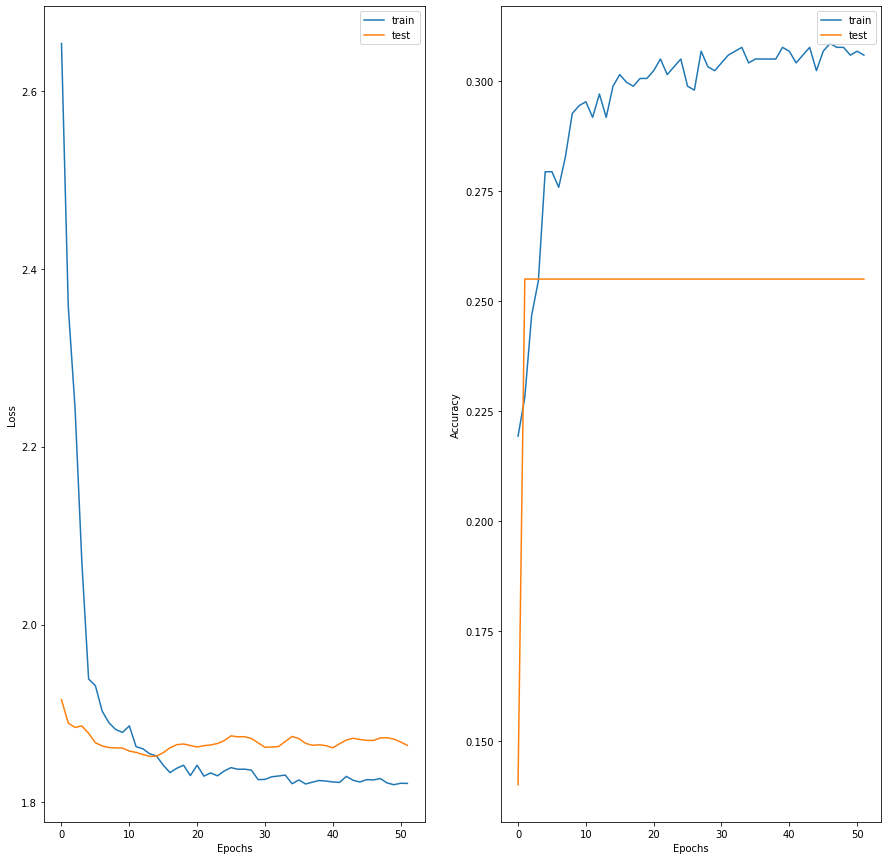

In [38]:
display_learning_curves(history)

In [39]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 30.5%


In [40]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)
    return np.array(instances)

def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [41]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 15.58%
- Genetic_Algorithms: 14.25%
- Neural_Networks: 18.53%
- Probabilistic_Methods: 12.8%
- Reinforcement_Learning: 11.04%
- Rule_Learning: 11.22%
- Theory: 16.58%
Instance 2:
- Case_Based: 15.61%
- Genetic_Algorithms: 14.29%
- Neural_Networks: 18.48%
- Probabilistic_Methods: 12.76%
- Reinforcement_Learning: 11.03%
- Rule_Learning: 11.22%
- Theory: 16.61%
Instance 3:
- Case_Based: 15.65%
- Genetic_Algorithms: 14.24%
- Neural_Networks: 18.43%
- Probabilistic_Methods: 12.75%
- Reinforcement_Learning: 11.03%
- Rule_Learning: 11.27%
- Theory: 16.64%
Instance 4:
- Case_Based: 15.67%
- Genetic_Algorithms: 14.27%
- Neural_Networks: 18.4%
- Probabilistic_Methods: 12.73%
- Reinforcement_Learning: 11.0%
- Rule_Learning: 11.27%
- Theory: 16.65%
Instance 5:
- Case_Based: 15.59%
- Genetic_Algorithms: 14.27%
- Neural_Networks: 18.47%
- Probabilistic_Methods: 12.79%
- Reinforcement_Learning: 11.02%
- Rule_Learning: 11.26%
- Theory: 16.61%
Instance 6:
- Case_Based: 15.58%


In [43]:
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32)
graph_info = (node_features, edges, edge_weights)
print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [50]:
class GraphConvLayer(layers.Layer):
    def __init__(self, hidden_units, dropout_rate=0.2, aggregation_type="mean", combination_type="concat", 
                 normalize=False, *args, **kwargs):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize
        
        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(units=hidden_units, activation="tanh", recurrent_activation="sigmoid", 
                                       dropout=dropout_rate, return_state=True, recurrent_dropout=dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)
    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages
    def aggregate(self, node_indices, neighbour_messages):
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type=="sum":
            aggregated_message = tf.math.unsorted_segment_sum(neighbour_messages, node_indices, 
                                                              num_segments=num_nodes)
        elif self.aggregation_type=="mean":
            aggregated_message = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, 
                                                               num_segments=num_nodes)
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(neighbour_messages, node_indices, 
                                                              num_segments=num_nodes)
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")
        return aggregated_message
    def update(self, node_representations, aggregated_messages):
        if self.combination_type == "gru":
            h = tf.stack([node_representations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            h = tf.concat([node_representations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            h = node_representations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings
    def call(self, inputs):
        node_representations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_representations = tf.gather(node_representations, neighbour_indices)
        neighbour_messages = self.prepare(neighbour_representations, edge_weights)
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        return self.update(node_representations, aggregated_messages)

In [51]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(self, graph_info, num_classes, hidden_units, aggregation_type="sum", combination_type="concat", 
                dropout_rate=0.2, normalize=True, *args, **kwargs):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        self.conv1 = GraphConvLayer(hidden_units, dropout_rate, aggregation_type, combination_type, normalize, 
                                   name="graph_conv1")
        self.conv2 = GraphConvLayer(hidden_units, dropout_rate, aggregation_type, combination_type, normalize, 
                                   name="graph_conv2")
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")
    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

In [52]:
gnn_model = GNNNodeClassifier(graph_info=graph_info, num_classes=num_classes, hidden_units=hidden_units, 
                              dropout_rate=dropout_rate, name="gnn_model")
print("GNN output shape:", gnn_model([1, 10, 100]))
gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.0789861   0.07287894  0.17499287 -0.08137141  0.07534211 -0.08939753
  -0.16716556]
 [ 0.05062952  0.02268125 -0.06393871 -0.00566974  0.08304619 -0.03978237
  -0.02789707]
 [-0.00249065  0.055916   -0.04326043 -0.07752558 -0.04279576 -0.1130365
  -0.1563306 ]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                             

In [53]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 4s 241ms/step - loss: 2.1896 - acc: 0.1963 - val_loss: 1.8992 - val_acc: 0.2200
Epoch 2/300
5/5 [==============================] - 1s 145ms/step - loss: 1.9406 - acc: 0.2759 - val_loss: 1.8932 - val_acc: 0.2850
Epoch 3/300
5/5 [==============================] - 1s 143ms/step - loss: 1.9141 - acc: 0.2670 - val_loss: 1.8893 - val_acc: 0.2650
Epoch 4/300
5/5 [==============================] - 1s 135ms/step - loss: 1.8685 - acc: 0.2750 - val_loss: 1.8841 - val_acc: 0.2550
Epoch 5/300
5/5 [==============================] - 1s 140ms/step - loss: 1.8591 - acc: 0.2776 - val_loss: 1.8724 - val_acc: 0.2550
Epoch 6/300
5/5 [==============================] - 1s 149ms/step - loss: 1.8109 - acc: 0.2971 - val_loss: 1.8585 - val_acc: 0.2550
Epoch 7/300
5/5 [==============================] - 1s 150ms/step - loss: 1.8081 - acc: 0.3033 - val_loss: 1.8402 - val_acc: 0.2550
Epoch 8/300
5/5 [==============================] - 1s 153ms/step - loss: 1.7955 - a

Epoch 125/300
5/5 [==============================] - 1s 153ms/step - loss: 0.4591 - acc: 0.8506 - val_loss: 0.7143 - val_acc: 0.8100
Epoch 126/300
5/5 [==============================] - 1s 174ms/step - loss: 0.4619 - acc: 0.8444 - val_loss: 0.7227 - val_acc: 0.8050
Epoch 127/300
5/5 [==============================] - 1s 167ms/step - loss: 0.4829 - acc: 0.8382 - val_loss: 0.7431 - val_acc: 0.7950
Epoch 128/300
5/5 [==============================] - 1s 150ms/step - loss: 0.4907 - acc: 0.8373 - val_loss: 0.7541 - val_acc: 0.8050
Epoch 129/300
5/5 [==============================] - 1s 152ms/step - loss: 0.4474 - acc: 0.8550 - val_loss: 0.7507 - val_acc: 0.8100
Epoch 130/300
5/5 [==============================] - 1s 141ms/step - loss: 0.4717 - acc: 0.8470 - val_loss: 0.7325 - val_acc: 0.8100
Epoch 131/300
5/5 [==============================] - 1s 142ms/step - loss: 0.3998 - acc: 0.8630 - val_loss: 0.7324 - val_acc: 0.8150
Epoch 132/300
5/5 [==============================] - 1s 143ms/step - 

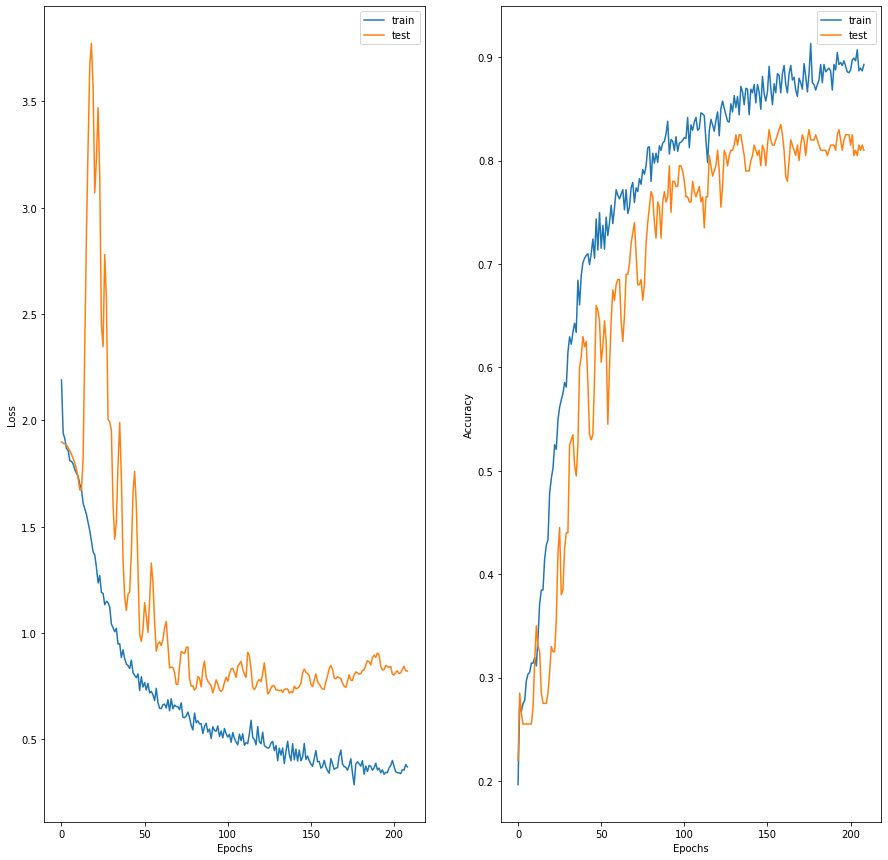

In [55]:
display_learning_curves(history)

In [56]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 81.77%


In [57]:
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])

new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    selected_paper_indices = np.concatenate([selected_paper_indices1, selected_paper_indices2], axis=0)
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])
new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [58]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape: ", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape:  (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 0.08%
- Genetic_Algorithms: 99.51%
- Neural_Networks: 0.08%
- Probabilistic_Methods: 0.05%
- Reinforcement_Learning: 0.21%
- Rule_Learning: 0.05%
- Theory: 0.02%
Instance 2:
- Case_Based: 0.13%
- Genetic_Algorithms: 99.42%
- Neural_Networks: 0.06%
- Probabilistic_Methods: 0.04%
- Reinforcement_Learning: 0.16%
- Rule_Learning: 0.14%
- Theory: 0.04%
Instance 3:
- Case_Based: 0.81%
- Genetic_Algorithms: 2.54%
- Neural_Networks: 76.15%
- Probabilistic_Methods: 3.11%
- Reinforcement_Learning: 0.69%
- Rule_Learning: 1.05%
- Theory: 15.64%
Instance 4:
- Case_Based: 0.22%
- Genetic_Algorithms: 71.49%
- Neural_Networks: 3.03%
- Probabilistic_Methods: 23.93%
- Reinforcement_Learning: 0.36%
- Rule_Learning: 0.15%
- Theory: 0.81%
Instance 5:
- Case_Based: 0.02%
- Genetic_Algorithms: 0.06%
- Neural_Networks: 99.71%
- Probabilistic_Met

# Project 81

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [64]:
class Antirectifier(layers.Layer):
    def __init__(self, initializer="he_normal", **kwargs):
        super(Antirectifier, self).__init__(**kwargs)
        self.initializer = keras.initializers.get(initializer)

    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(output_dim * 2, output_dim),
            initializer=self.initializer,
            name="kernel",
            trainable=True,
        )

    def call(self, inputs):
        inputs -= tf.reduce_mean(inputs, axis=-1, keepdims=True)
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        concatenated = tf.concat([pos, neg], axis=-1)
        mixed = tf.matmul(concatenated, self.kernel)
        return mixed

    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(Antirectifier, self).get_config()
        config = {"initializer": keras.initializers.serialize(self.initializer)}
        return dict(list(base_config.items()) + list(config.items()))


In [65]:
batch_size = 128
num_classes = 10
epochs = 20

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

model = keras.Sequential([
    keras.Input(shape=(784, )), 
    layers.Dense(256), 
    Antirectifier(), 
    layers.Dense(256),
    Antirectifier(), 
    layers.Dropout(0.5),
    layers.Dense(10),
])
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             optimizer=keras.optimizers.RMSprop(), 
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.15)


60000 train samples
10000 test samples
Epoch 1/20
399/399 [==============================] - 7s 15ms/step - loss: 0.3779 - sparse_categorical_accuracy: 0.8904 - val_loss: 0.1136 - val_sparse_categorical_accuracy: 0.9672
Epoch 2/20
399/399 [==============================] - 6s 14ms/step - loss: 0.1819 - sparse_categorical_accuracy: 0.9496 - val_loss: 0.2088 - val_sparse_categorical_accuracy: 0.9512
Epoch 3/20
399/399 [==============================] - 5s 14ms/step - loss: 0.1378 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.1804 - val_sparse_categorical_accuracy: 0.9543
Epoch 4/20
399/399 [==============================] - 6s 14ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.1794 - val_sparse_categorical_accuracy: 0.9581
Epoch 5/20
399/399 [==============================] - 5s 14ms/step - loss: 0.0990 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.1409 - val_sparse_categorical_accuracy: 0.9684
Epoch 6/20
399/399 [==============================] - 5s

In [66]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3986 - sparse_categorical_accuracy: 0.9569


[0.3985612690448761, 0.9569000005722046]

# Project 82

In [67]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

In [69]:
def get_train_and_test_splits(train_size, batch_size=1):
    dataset = (tfds.load(name="wine_quality", as_supervised=True, split="train")
               .map(lambda x, y: (x, tf.cast(y, tf.float32)))
              .prefetch(buffer_size=dataset_size)
              .cache())
    train_dataset = (dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size))
    test_dataset = dataset.skip(train_size).batch(batch_size)
    return train_dataset, test_dataset

In [87]:
hidden_units = [8, 8]
learning_rate = 0.001
def run_experiment(model, loss, train_dataset, test_dataset):
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), loss=loss, 
                 metrics=[keras.metrics.RootMeanSquaredError()])
    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")
    
    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [88]:
FEATURE_NAMES = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]
def create_model_inputs():
    inputs ={}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(name=feature_name, shape=(1, ), dtype=tf.float32)
    return inputs

In [89]:
def create_baseline_model():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [90]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)
train_dataset, test_dataset = get_train_and_test_splits(train_size, batch_size)

In [91]:
num_epochs = 100
mse_loss = keras.losses.MeanSquaredError()
baseline_model = create_baseline_model()
run_experiment(baseline_model, mse_loss, train_dataset, test_dataset)

Start training the model...
Epoch 1/100
17/17 [==============================] - 3s 64ms/step - loss: 49.4078 - root_mean_squared_error: 7.0291 - val_loss: 47.5322 - val_root_mean_squared_error: 6.8944
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 46.9593 - root_mean_squared_error: 6.8527 - val_loss: 45.2075 - val_root_mean_squared_error: 6.7237
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 44.9227 - root_mean_squared_error: 6.7024 - val_loss: 43.0165 - val_root_mean_squared_error: 6.5587
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 42.9934 - root_mean_squared_error: 6.5569 - val_loss: 41.0007 - val_root_mean_squared_error: 6.4032
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 41.1380 - root_mean_squared_error: 6.4139 - val_loss: 39.1381 - val_root_mean_squared_error: 6.2560
Epoch 6/100
17/17 [==============================] - 0s 14ms/step - loss: 39.3539 - root_mean_squared_

Epoch 48/100
17/17 [==============================] - 0s 14ms/step - loss: 4.3636 - root_mean_squared_error: 2.0889 - val_loss: 3.9730 - val_root_mean_squared_error: 1.9932
Epoch 49/100
17/17 [==============================] - 0s 14ms/step - loss: 3.8698 - root_mean_squared_error: 1.9672 - val_loss: 3.5085 - val_root_mean_squared_error: 1.8731
Epoch 50/100
17/17 [==============================] - 0s 14ms/step - loss: 3.4100 - root_mean_squared_error: 1.8466 - val_loss: 3.0776 - val_root_mean_squared_error: 1.7543
Epoch 51/100
17/17 [==============================] - 0s 13ms/step - loss: 2.9818 - root_mean_squared_error: 1.7268 - val_loss: 2.6761 - val_root_mean_squared_error: 1.6359
Epoch 52/100
17/17 [==============================] - 0s 14ms/step - loss: 2.5882 - root_mean_squared_error: 1.6088 - val_loss: 2.3143 - val_root_mean_squared_error: 1.5213
Epoch 53/100
17/17 [==============================] - 0s 14ms/step - loss: 2.2318 - root_mean_squared_error: 1.4939 - val_loss: 1.9899 

In [94]:
samples = 10
examples, targets = list(test_dataset.unbatch().shuffle(batch_size * 10).batch(samples))[0]
predicted = baseline_model(examples).numpy()
for idx in range(samples):
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")

Predicted: 5.2 - Actual: 4.0
Predicted: 5.9 - Actual: 6.0
Predicted: 6.0 - Actual: 5.0
Predicted: 5.6 - Actual: 6.0
Predicted: 5.5 - Actual: 6.0
Predicted: 4.6 - Actual: 4.0
Predicted: 5.7 - Actual: 6.0
Predicted: 5.9 - Actual: 4.0
Predicted: 5.2 - Actual: 5.0
Predicted: 5.9 - Actual: 5.0


In [95]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential([
        tfp.layers.DistributionLambda(lambda t: 
                                      tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), 
                                                                               scale_diag=tf.ones(n)))
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential([
        tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfp.layers.MultivariateNormalTriL(n),
    ])
    return posterior_model

In [98]:
def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)
    for units in hidden_units:
        features = tfp.layers.DenseVariational(units=units, make_prior_fn=prior, make_posterior_fn=posterior, 
                                              kl_weight=1 / train_size, activation="sigmoid")(features)
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [99]:
num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = train_dataset.unbatch().take(train_sample_size).batch(batch_size)
bnn_model_small = create_bnn_model(train_sample_size)
run_experiment(bnn_model_small, mse_loss, small_train_dataset, test_dataset)

Start training the model...
Epoch 1/500
5/5 [==============================] - 5s 358ms/step - loss: 38.2505 - root_mean_squared_error: 6.1835 - val_loss: 37.7748 - val_root_mean_squared_error: 6.1452
Epoch 2/500
5/5 [==============================] - 0s 44ms/step - loss: 36.4492 - root_mean_squared_error: 6.0360 - val_loss: 32.8295 - val_root_mean_squared_error: 5.7282
Epoch 3/500
5/5 [==============================] - 0s 44ms/step - loss: 35.5362 - root_mean_squared_error: 5.9602 - val_loss: 32.3550 - val_root_mean_squared_error: 5.6868
Epoch 4/500
5/5 [==============================] - 0s 46ms/step - loss: 34.1448 - root_mean_squared_error: 5.8421 - val_loss: 33.0108 - val_root_mean_squared_error: 5.7441
Epoch 5/500
5/5 [==============================] - 0s 44ms/step - loss: 33.1412 - root_mean_squared_error: 5.7555 - val_loss: 32.5398 - val_root_mean_squared_error: 5.7029
Epoch 6/500
5/5 [==============================] - 0s 42ms/step - loss: 34.9480 - root_mean_squared_error: 5.91

5/5 [==============================] - 0s 43ms/step - loss: 6.9337 - root_mean_squared_error: 2.6287 - val_loss: 6.1534 - val_root_mean_squared_error: 2.4759
Epoch 96/500
5/5 [==============================] - 0s 42ms/step - loss: 6.2449 - root_mean_squared_error: 2.4945 - val_loss: 6.2683 - val_root_mean_squared_error: 2.4983
Epoch 97/500
5/5 [==============================] - 0s 40ms/step - loss: 7.3212 - root_mean_squared_error: 2.7017 - val_loss: 6.3297 - val_root_mean_squared_error: 2.5123
Epoch 98/500
5/5 [==============================] - 0s 43ms/step - loss: 6.3799 - root_mean_squared_error: 2.5216 - val_loss: 7.7563 - val_root_mean_squared_error: 2.7813
Epoch 99/500
5/5 [==============================] - 0s 42ms/step - loss: 5.9503 - root_mean_squared_error: 2.4352 - val_loss: 6.7650 - val_root_mean_squared_error: 2.5963
Epoch 100/500
5/5 [==============================] - 0s 43ms/step - loss: 5.9812 - root_mean_squared_error: 2.4418 - val_loss: 6.6397 - val_root_mean_squared_

Epoch 143/500
5/5 [==============================] - 0s 44ms/step - loss: 1.1985 - root_mean_squared_error: 1.0816 - val_loss: 1.1568 - val_root_mean_squared_error: 1.0619
Epoch 144/500
5/5 [==============================] - 0s 43ms/step - loss: 1.1721 - root_mean_squared_error: 1.0688 - val_loss: 1.3799 - val_root_mean_squared_error: 1.1632
Epoch 145/500
5/5 [==============================] - 0s 42ms/step - loss: 1.3609 - root_mean_squared_error: 1.1554 - val_loss: 1.1477 - val_root_mean_squared_error: 1.0577
Epoch 146/500
5/5 [==============================] - 0s 45ms/step - loss: 1.1136 - root_mean_squared_error: 1.0397 - val_loss: 1.1101 - val_root_mean_squared_error: 1.0386
Epoch 147/500
5/5 [==============================] - 0s 42ms/step - loss: 1.2586 - root_mean_squared_error: 1.1091 - val_loss: 1.0153 - val_root_mean_squared_error: 0.9933
Epoch 148/500
5/5 [==============================] - 0s 39ms/step - loss: 1.2737 - root_mean_squared_error: 1.1171 - val_loss: 0.9748 - val_

Epoch 238/500
5/5 [==============================] - 0s 43ms/step - loss: 0.7580 - root_mean_squared_error: 0.8539 - val_loss: 0.7470 - val_root_mean_squared_error: 0.8502
Epoch 239/500
5/5 [==============================] - 0s 48ms/step - loss: 0.7333 - root_mean_squared_error: 0.8409 - val_loss: 0.7550 - val_root_mean_squared_error: 0.8509
Epoch 240/500
5/5 [==============================] - 0s 42ms/step - loss: 0.7280 - root_mean_squared_error: 0.8378 - val_loss: 0.7707 - val_root_mean_squared_error: 0.8662
Epoch 241/500
5/5 [==============================] - 0s 43ms/step - loss: 0.7567 - root_mean_squared_error: 0.8528 - val_loss: 0.7344 - val_root_mean_squared_error: 0.8404
Epoch 242/500
5/5 [==============================] - 0s 44ms/step - loss: 0.7790 - root_mean_squared_error: 0.8678 - val_loss: 0.8032 - val_root_mean_squared_error: 0.8786
Epoch 243/500
5/5 [==============================] - 0s 42ms/step - loss: 0.6834 - root_mean_squared_error: 0.8070 - val_loss: 0.7658 - val_

Epoch 333/500
5/5 [==============================] - 0s 40ms/step - loss: 0.7142 - root_mean_squared_error: 0.8276 - val_loss: 0.7132 - val_root_mean_squared_error: 0.8268
Epoch 334/500
5/5 [==============================] - 0s 46ms/step - loss: 0.6873 - root_mean_squared_error: 0.8116 - val_loss: 0.7712 - val_root_mean_squared_error: 0.8621
Epoch 335/500
5/5 [==============================] - 0s 43ms/step - loss: 0.6878 - root_mean_squared_error: 0.8089 - val_loss: 0.7106 - val_root_mean_squared_error: 0.8256
Epoch 336/500
5/5 [==============================] - 0s 42ms/step - loss: 0.7119 - root_mean_squared_error: 0.8246 - val_loss: 0.7243 - val_root_mean_squared_error: 0.8347
Epoch 337/500
5/5 [==============================] - 0s 41ms/step - loss: 0.7058 - root_mean_squared_error: 0.8230 - val_loss: 0.6925 - val_root_mean_squared_error: 0.8143
Epoch 338/500
5/5 [==============================] - 0s 42ms/step - loss: 0.6973 - root_mean_squared_error: 0.8180 - val_loss: 0.6555 - val_

Epoch 428/500
5/5 [==============================] - 0s 50ms/step - loss: 0.6434 - root_mean_squared_error: 0.7823 - val_loss: 0.6793 - val_root_mean_squared_error: 0.8070
Epoch 429/500
5/5 [==============================] - 0s 42ms/step - loss: 0.6466 - root_mean_squared_error: 0.7860 - val_loss: 0.6889 - val_root_mean_squared_error: 0.8135
Epoch 430/500
5/5 [==============================] - 0s 42ms/step - loss: 0.6543 - root_mean_squared_error: 0.7906 - val_loss: 0.6436 - val_root_mean_squared_error: 0.7835
Epoch 431/500
5/5 [==============================] - 0s 44ms/step - loss: 0.6776 - root_mean_squared_error: 0.8059 - val_loss: 0.6963 - val_root_mean_squared_error: 0.8189
Epoch 432/500
5/5 [==============================] - 0s 48ms/step - loss: 0.6570 - root_mean_squared_error: 0.7907 - val_loss: 0.6531 - val_root_mean_squared_error: 0.7922
Epoch 433/500
5/5 [==============================] - 0s 43ms/step - loss: 0.6533 - root_mean_squared_error: 0.7911 - val_loss: 0.7495 - val_

In [102]:
def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)
    
    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()
    
    for idx in range(samples):
        print(f"Predictions mean: {round(prediction_mean[idx], 2)}, "
             f"min: {round(prediction_min[idx], 2)}, "
             f"max: {round(prediction_max[idx], 2)}, "
             f"range: {round(prediction_range[idx], 2)} -"
             f"Actual: {targets[idx]}")
compute_predictions(bnn_model_small)

Predictions mean: 4.82, min: 3.96, max: 5.61, range: 1.65 -Actual: 4.0
Predictions mean: 5.6, min: 4.99, max: 6.19, range: 1.2 -Actual: 6.0
Predictions mean: 5.98, min: 5.47, max: 6.3, range: 0.83 -Actual: 5.0
Predictions mean: 5.57, min: 4.76, max: 6.13, range: 1.37 -Actual: 6.0
Predictions mean: 5.76, min: 5.12, max: 6.19, range: 1.07 -Actual: 6.0
Predictions mean: 4.86, min: 3.89, max: 5.92, range: 2.04 -Actual: 4.0
Predictions mean: 5.9, min: 5.34, max: 6.24, range: 0.9 -Actual: 6.0
Predictions mean: 5.41, min: 4.72, max: 6.06, range: 1.34 -Actual: 4.0
Predictions mean: 5.39, min: 4.39, max: 6.17, range: 1.78 -Actual: 5.0
Predictions mean: 5.76, min: 5.27, max: 6.19, range: 0.92 -Actual: 5.0


In [103]:
num_epochs = 500
bnn_model_full = create_bnn_model(train_size)
run_experiment(bnn_model_full, mse_loss, train_dataset, test_dataset)
compute_predictions(bnn_model_full)

Start training the model...
Epoch 1/500
17/17 [==============================] - 5s 95ms/step - loss: 27.2315 - root_mean_squared_error: 5.2180 - val_loss: 27.3522 - val_root_mean_squared_error: 5.2295
Epoch 2/500
17/17 [==============================] - 0s 15ms/step - loss: 24.0072 - root_mean_squared_error: 4.8993 - val_loss: 18.3280 - val_root_mean_squared_error: 4.2807
Epoch 3/500
17/17 [==============================] - 0s 15ms/step - loss: 21.2263 - root_mean_squared_error: 4.6068 - val_loss: 19.3980 - val_root_mean_squared_error: 4.4039
Epoch 4/500
17/17 [==============================] - 0s 15ms/step - loss: 20.2472 - root_mean_squared_error: 4.4991 - val_loss: 22.4211 - val_root_mean_squared_error: 4.7345
Epoch 5/500
17/17 [==============================] - 0s 15ms/step - loss: 17.5813 - root_mean_squared_error: 4.1924 - val_loss: 21.0265 - val_root_mean_squared_error: 4.5850
Epoch 6/500
17/17 [==============================] - 0s 16ms/step - loss: 19.0455 - root_mean_squared_

17/17 [==============================] - 0s 19ms/step - loss: 0.6660 - root_mean_squared_error: 0.8095 - val_loss: 0.6764 - val_root_mean_squared_error: 0.8163
Epoch 96/500
17/17 [==============================] - 0s 17ms/step - loss: 0.6702 - root_mean_squared_error: 0.8122 - val_loss: 0.6596 - val_root_mean_squared_error: 0.8060
Epoch 97/500
17/17 [==============================] - 0s 15ms/step - loss: 0.6971 - root_mean_squared_error: 0.8286 - val_loss: 0.6399 - val_root_mean_squared_error: 0.7935
Epoch 98/500
17/17 [==============================] - 0s 15ms/step - loss: 0.6653 - root_mean_squared_error: 0.8089 - val_loss: 0.6840 - val_root_mean_squared_error: 0.8212
Epoch 99/500
17/17 [==============================] - 0s 15ms/step - loss: 0.6826 - root_mean_squared_error: 0.8195 - val_loss: 0.6506 - val_root_mean_squared_error: 0.8005
Epoch 100/500
17/17 [==============================] - 0s 17ms/step - loss: 0.6783 - root_mean_squared_error: 0.8171 - val_loss: 0.6773 - val_root_m

17/17 [==============================] - 0s 14ms/step - loss: 0.6320 - root_mean_squared_error: 0.7875 - val_loss: 0.6236 - val_root_mean_squared_error: 0.7818
Epoch 190/500
17/17 [==============================] - 0s 15ms/step - loss: 0.6266 - root_mean_squared_error: 0.7839 - val_loss: 0.6166 - val_root_mean_squared_error: 0.7771
Epoch 191/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6277 - root_mean_squared_error: 0.7842 - val_loss: 0.6125 - val_root_mean_squared_error: 0.7742
Epoch 192/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6197 - root_mean_squared_error: 0.7795 - val_loss: 0.5958 - val_root_mean_squared_error: 0.7638
Epoch 193/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6283 - root_mean_squared_error: 0.7852 - val_loss: 0.6076 - val_root_mean_squared_error: 0.7709
Epoch 194/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6241 - root_mean_squared_error: 0.7823 - val_loss: 0.6093 - val_ro

17/17 [==============================] - 0s 23ms/step - loss: 0.6151 - root_mean_squared_error: 0.7758 - val_loss: 0.6249 - val_root_mean_squared_error: 0.7823
Epoch 284/500
17/17 [==============================] - 0s 15ms/step - loss: 0.6316 - root_mean_squared_error: 0.7870 - val_loss: 0.5995 - val_root_mean_squared_error: 0.7661
Epoch 285/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6203 - root_mean_squared_error: 0.7792 - val_loss: 0.6097 - val_root_mean_squared_error: 0.7732
Epoch 286/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6070 - root_mean_squared_error: 0.7707 - val_loss: 0.6136 - val_root_mean_squared_error: 0.7747
Epoch 287/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6131 - root_mean_squared_error: 0.7747 - val_loss: 0.6044 - val_root_mean_squared_error: 0.7683
Epoch 288/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6037 - root_mean_squared_error: 0.7684 - val_loss: 0.6146 - val_ro

17/17 [==============================] - 0s 15ms/step - loss: 0.6150 - root_mean_squared_error: 0.7758 - val_loss: 0.6040 - val_root_mean_squared_error: 0.7680
Epoch 378/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6017 - root_mean_squared_error: 0.7666 - val_loss: 0.6138 - val_root_mean_squared_error: 0.7742
Epoch 379/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6059 - root_mean_squared_error: 0.7695 - val_loss: 0.5886 - val_root_mean_squared_error: 0.7587
Epoch 380/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6007 - root_mean_squared_error: 0.7664 - val_loss: 0.6164 - val_root_mean_squared_error: 0.7771
Epoch 381/500
17/17 [==============================] - 0s 14ms/step - loss: 0.5930 - root_mean_squared_error: 0.7610 - val_loss: 0.5964 - val_root_mean_squared_error: 0.7645
Epoch 382/500
17/17 [==============================] - 0s 14ms/step - loss: 0.6021 - root_mean_squared_error: 0.7672 - val_loss: 0.6061 - val_ro

17/17 [==============================] - 0s 15ms/step - loss: 0.6003 - root_mean_squared_error: 0.7655 - val_loss: 0.5933 - val_root_mean_squared_error: 0.7603
Epoch 472/500
17/17 [==============================] - 0s 15ms/step - loss: 0.6091 - root_mean_squared_error: 0.7707 - val_loss: 0.6191 - val_root_mean_squared_error: 0.7768
Epoch 473/500
17/17 [==============================] - 0s 18ms/step - loss: 0.6077 - root_mean_squared_error: 0.7702 - val_loss: 0.6187 - val_root_mean_squared_error: 0.7769
Epoch 474/500
17/17 [==============================] - 0s 15ms/step - loss: 0.5954 - root_mean_squared_error: 0.7618 - val_loss: 0.5955 - val_root_mean_squared_error: 0.7614
Epoch 475/500
17/17 [==============================] - 0s 15ms/step - loss: 0.5959 - root_mean_squared_error: 0.7625 - val_loss: 0.6036 - val_root_mean_squared_error: 0.7674
Epoch 476/500
17/17 [==============================] - 0s 14ms/step - loss: 0.5993 - root_mean_squared_error: 0.7650 - val_loss: 0.6203 - val_ro

In [104]:
def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)
    
    for units in hidden_units:
        features = tfp.layers.DenseVariational(units=units, make_prior_fn=prior, make_posterior_fn=posterior, 
                                              kl_weight=1/train_size, activation="sigmoid")(features)
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [105]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)
num_epochs = 1000
prob_bnn_model = create_probablistic_bnn_model(train_size)
run_experiment(prob_bnn_model, negative_loglikelihood, train_dataset, test_dataset)

Start training the model...
Epoch 1/1000
17/17 [==============================] - 6s 96ms/step - loss: 121.6105 - root_mean_squared_error: 5.5403 - val_loss: 195.1804 - val_root_mean_squared_error: 5.3218
Epoch 2/1000
17/17 [==============================] - 0s 15ms/step - loss: 95.4605 - root_mean_squared_error: 5.3844 - val_loss: 118.1511 - val_root_mean_squared_error: 5.3599
Epoch 3/1000
17/17 [==============================] - 0s 17ms/step - loss: 84.1821 - root_mean_squared_error: 5.4380 - val_loss: 75.1368 - val_root_mean_squared_error: 5.2164
Epoch 4/1000
17/17 [==============================] - 0s 20ms/step - loss: 58.3954 - root_mean_squared_error: 5.3049 - val_loss: 30.2438 - val_root_mean_squared_error: 5.1743
Epoch 5/1000
17/17 [==============================] - 0s 19ms/step - loss: 66.8564 - root_mean_squared_error: 5.3146 - val_loss: 39.5729 - val_root_mean_squared_error: 4.9830
Epoch 6/1000
17/17 [==============================] - 0s 14ms/step - loss: 47.1751 - root_mean

Epoch 48/1000
17/17 [==============================] - 0s 18ms/step - loss: 1.7194 - root_mean_squared_error: 2.1697 - val_loss: 1.6691 - val_root_mean_squared_error: 1.9826
Epoch 49/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.6215 - root_mean_squared_error: 1.9819 - val_loss: 1.6126 - val_root_mean_squared_error: 1.9346
Epoch 50/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.5801 - root_mean_squared_error: 1.8755 - val_loss: 1.5962 - val_root_mean_squared_error: 1.8001
Epoch 51/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.5629 - root_mean_squared_error: 1.8502 - val_loss: 1.4709 - val_root_mean_squared_error: 1.6725
Epoch 52/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.5210 - root_mean_squared_error: 1.7695 - val_loss: 1.4148 - val_root_mean_squared_error: 1.5303
Epoch 53/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.4810 - root_mean_squared_error: 1.6567 - val_loss: 1

Epoch 142/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.2052 - root_mean_squared_error: 1.1456 - val_loss: 1.1862 - val_root_mean_squared_error: 1.0912
Epoch 143/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.2229 - root_mean_squared_error: 1.1630 - val_loss: 1.2096 - val_root_mean_squared_error: 1.1270
Epoch 144/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.2036 - root_mean_squared_error: 1.1516 - val_loss: 1.1811 - val_root_mean_squared_error: 1.1505
Epoch 145/1000
17/17 [==============================] - 0s 18ms/step - loss: 1.2414 - root_mean_squared_error: 1.1376 - val_loss: 1.2082 - val_root_mean_squared_error: 1.1218
Epoch 146/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.2018 - root_mean_squared_error: 1.1521 - val_loss: 1.2097 - val_root_mean_squared_error: 1.0998
Epoch 147/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.2123 - root_mean_squared_error: 1.1611 - val_l

Epoch 189/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1855 - root_mean_squared_error: 1.0987 - val_loss: 1.1935 - val_root_mean_squared_error: 1.0898
Epoch 190/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1877 - root_mean_squared_error: 1.1124 - val_loss: 1.2117 - val_root_mean_squared_error: 1.2257
Epoch 191/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1839 - root_mean_squared_error: 1.1225 - val_loss: 1.1754 - val_root_mean_squared_error: 1.1313
Epoch 192/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1950 - root_mean_squared_error: 1.0955 - val_loss: 1.1801 - val_root_mean_squared_error: 1.1174
Epoch 193/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1770 - root_mean_squared_error: 1.0857 - val_loss: 1.2001 - val_root_mean_squared_error: 1.1985
Epoch 194/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1889 - root_mean_squared_error: 1.1220 - val_l

Epoch 236/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1739 - root_mean_squared_error: 1.0865 - val_loss: 1.1705 - val_root_mean_squared_error: 1.0506
Epoch 237/1000
17/17 [==============================] - 0s 16ms/step - loss: 1.1770 - root_mean_squared_error: 1.0806 - val_loss: 1.1826 - val_root_mean_squared_error: 1.1252
Epoch 238/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1836 - root_mean_squared_error: 1.1084 - val_loss: 1.1654 - val_root_mean_squared_error: 1.0915
Epoch 239/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1852 - root_mean_squared_error: 1.1073 - val_loss: 1.1658 - val_root_mean_squared_error: 1.0816
Epoch 240/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1736 - root_mean_squared_error: 1.1105 - val_loss: 1.1609 - val_root_mean_squared_error: 1.0699
Epoch 241/1000
17/17 [==============================] - 0s 16ms/step - loss: 1.1762 - root_mean_squared_error: 1.1057 - val_l

Epoch 283/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1703 - root_mean_squared_error: 1.0822 - val_loss: 1.1614 - val_root_mean_squared_error: 1.0720
Epoch 284/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1765 - root_mean_squared_error: 1.1136 - val_loss: 1.2020 - val_root_mean_squared_error: 1.1122
Epoch 285/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1799 - root_mean_squared_error: 1.0914 - val_loss: 1.1782 - val_root_mean_squared_error: 1.1185
Epoch 286/1000
17/17 [==============================] - 0s 13ms/step - loss: 1.1689 - root_mean_squared_error: 1.1110 - val_loss: 1.1556 - val_root_mean_squared_error: 1.0900
Epoch 287/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1872 - root_mean_squared_error: 1.1134 - val_loss: 1.1808 - val_root_mean_squared_error: 1.1000
Epoch 288/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1717 - root_mean_squared_error: 1.0809 - val_l

Epoch 330/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1705 - root_mean_squared_error: 1.0946 - val_loss: 1.1585 - val_root_mean_squared_error: 1.0889
Epoch 331/1000
17/17 [==============================] - 0s 18ms/step - loss: 1.1727 - root_mean_squared_error: 1.1010 - val_loss: 1.1748 - val_root_mean_squared_error: 1.0349
Epoch 332/1000
17/17 [==============================] - 0s 17ms/step - loss: 1.1795 - root_mean_squared_error: 1.1046 - val_loss: 1.1617 - val_root_mean_squared_error: 1.1049
Epoch 333/1000
17/17 [==============================] - 0s 18ms/step - loss: 1.1748 - root_mean_squared_error: 1.1126 - val_loss: 1.1969 - val_root_mean_squared_error: 1.1065
Epoch 334/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1775 - root_mean_squared_error: 1.0867 - val_loss: 1.1786 - val_root_mean_squared_error: 1.0938
Epoch 335/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1628 - root_mean_squared_error: 1.0934 - val_l

Epoch 377/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1639 - root_mean_squared_error: 1.0961 - val_loss: 1.1646 - val_root_mean_squared_error: 1.0612
Epoch 378/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1636 - root_mean_squared_error: 1.0797 - val_loss: 1.1715 - val_root_mean_squared_error: 1.0612
Epoch 379/1000
17/17 [==============================] - 0s 13ms/step - loss: 1.1700 - root_mean_squared_error: 1.0778 - val_loss: 1.1501 - val_root_mean_squared_error: 1.0832
Epoch 380/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1688 - root_mean_squared_error: 1.1091 - val_loss: 1.1591 - val_root_mean_squared_error: 1.0493
Epoch 381/1000
17/17 [==============================] - 0s 13ms/step - loss: 1.1722 - root_mean_squared_error: 1.0894 - val_loss: 1.1731 - val_root_mean_squared_error: 1.0771
Epoch 382/1000
17/17 [==============================] - 0s 17ms/step - loss: 1.1757 - root_mean_squared_error: 1.0953 - val_l

Epoch 424/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1746 - root_mean_squared_error: 1.0905 - val_loss: 1.1629 - val_root_mean_squared_error: 1.0727
Epoch 425/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1675 - root_mean_squared_error: 1.0809 - val_loss: 1.1544 - val_root_mean_squared_error: 1.0692
Epoch 426/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1739 - root_mean_squared_error: 1.0808 - val_loss: 1.1648 - val_root_mean_squared_error: 1.0945
Epoch 427/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1658 - root_mean_squared_error: 1.0994 - val_loss: 1.1473 - val_root_mean_squared_error: 1.0732
Epoch 428/1000
17/17 [==============================] - 0s 17ms/step - loss: 1.1746 - root_mean_squared_error: 1.0882 - val_loss: 1.1825 - val_root_mean_squared_error: 1.1110
Epoch 429/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1635 - root_mean_squared_error: 1.0962 - val_l

Epoch 471/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1575 - root_mean_squared_error: 1.0756 - val_loss: 1.1481 - val_root_mean_squared_error: 1.0622
Epoch 472/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1666 - root_mean_squared_error: 1.0889 - val_loss: 1.1874 - val_root_mean_squared_error: 1.1455
Epoch 473/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1630 - root_mean_squared_error: 1.0967 - val_loss: 1.1562 - val_root_mean_squared_error: 1.0601
Epoch 474/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1636 - root_mean_squared_error: 1.0870 - val_loss: 1.1523 - val_root_mean_squared_error: 1.0509
Epoch 475/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1692 - root_mean_squared_error: 1.0885 - val_loss: 1.1649 - val_root_mean_squared_error: 1.0487
Epoch 476/1000
17/17 [==============================] - 0s 13ms/step - loss: 1.1615 - root_mean_squared_error: 1.0855 - val_l

Epoch 518/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1656 - root_mean_squared_error: 1.0921 - val_loss: 1.1584 - val_root_mean_squared_error: 1.0542
Epoch 519/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1612 - root_mean_squared_error: 1.0865 - val_loss: 1.1535 - val_root_mean_squared_error: 1.1081
Epoch 520/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1668 - root_mean_squared_error: 1.0758 - val_loss: 1.1777 - val_root_mean_squared_error: 1.1053
Epoch 521/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1570 - root_mean_squared_error: 1.0882 - val_loss: 1.1584 - val_root_mean_squared_error: 1.0909
Epoch 522/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1668 - root_mean_squared_error: 1.0864 - val_loss: 1.1672 - val_root_mean_squared_error: 1.1001
Epoch 523/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1693 - root_mean_squared_error: 1.0892 - val_l

Epoch 565/1000
17/17 [==============================] - 0s 13ms/step - loss: 1.1569 - root_mean_squared_error: 1.0739 - val_loss: 1.1503 - val_root_mean_squared_error: 1.0841
Epoch 566/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1628 - root_mean_squared_error: 1.0700 - val_loss: 1.1709 - val_root_mean_squared_error: 1.0817
Epoch 567/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1577 - root_mean_squared_error: 1.0664 - val_loss: 1.1627 - val_root_mean_squared_error: 1.0240
Epoch 568/1000
17/17 [==============================] - 0s 19ms/step - loss: 1.1597 - root_mean_squared_error: 1.0799 - val_loss: 1.1467 - val_root_mean_squared_error: 1.0487
Epoch 569/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1573 - root_mean_squared_error: 1.0792 - val_loss: 1.1515 - val_root_mean_squared_error: 1.0976
Epoch 570/1000
17/17 [==============================] - 0s 18ms/step - loss: 1.1584 - root_mean_squared_error: 1.0889 - val_l

Epoch 612/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1614 - root_mean_squared_error: 1.0957 - val_loss: 1.1522 - val_root_mean_squared_error: 1.0717
Epoch 613/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1625 - root_mean_squared_error: 1.0759 - val_loss: 1.1587 - val_root_mean_squared_error: 1.1018
Epoch 614/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1574 - root_mean_squared_error: 1.0835 - val_loss: 1.1436 - val_root_mean_squared_error: 1.0847
Epoch 615/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1623 - root_mean_squared_error: 1.0794 - val_loss: 1.1584 - val_root_mean_squared_error: 1.0416
Epoch 616/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1584 - root_mean_squared_error: 1.0893 - val_loss: 1.1567 - val_root_mean_squared_error: 1.0725
Epoch 617/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1512 - root_mean_squared_error: 1.0615 - val_l

Epoch 659/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1629 - root_mean_squared_error: 1.0754 - val_loss: 1.1513 - val_root_mean_squared_error: 1.0179
Epoch 660/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1566 - root_mean_squared_error: 1.1019 - val_loss: 1.1422 - val_root_mean_squared_error: 1.0189
Epoch 661/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1585 - root_mean_squared_error: 1.0759 - val_loss: 1.1578 - val_root_mean_squared_error: 1.0450
Epoch 662/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1517 - root_mean_squared_error: 1.0558 - val_loss: 1.1673 - val_root_mean_squared_error: 1.1131
Epoch 663/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1529 - root_mean_squared_error: 1.0737 - val_loss: 1.1495 - val_root_mean_squared_error: 1.0879
Epoch 664/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1638 - root_mean_squared_error: 1.0751 - val_l

Epoch 706/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1506 - root_mean_squared_error: 1.0866 - val_loss: 1.1535 - val_root_mean_squared_error: 1.0436
Epoch 707/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1591 - root_mean_squared_error: 1.0732 - val_loss: 1.1521 - val_root_mean_squared_error: 1.0408
Epoch 708/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1590 - root_mean_squared_error: 1.0809 - val_loss: 1.1760 - val_root_mean_squared_error: 1.0532
Epoch 709/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1514 - root_mean_squared_error: 1.0609 - val_loss: 1.1604 - val_root_mean_squared_error: 1.0418
Epoch 710/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1609 - root_mean_squared_error: 1.0711 - val_loss: 1.1571 - val_root_mean_squared_error: 1.0294
Epoch 711/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1564 - root_mean_squared_error: 1.0828 - val_l

Epoch 753/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1561 - root_mean_squared_error: 1.0762 - val_loss: 1.1520 - val_root_mean_squared_error: 1.0983
Epoch 754/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1551 - root_mean_squared_error: 1.0715 - val_loss: 1.1534 - val_root_mean_squared_error: 1.0344
Epoch 755/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1613 - root_mean_squared_error: 1.0597 - val_loss: 1.1442 - val_root_mean_squared_error: 1.1070
Epoch 756/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1544 - root_mean_squared_error: 1.0706 - val_loss: 1.1756 - val_root_mean_squared_error: 1.0934
Epoch 757/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1524 - root_mean_squared_error: 1.0524 - val_loss: 1.1416 - val_root_mean_squared_error: 1.0699
Epoch 758/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1580 - root_mean_squared_error: 1.0691 - val_l

Epoch 800/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1594 - root_mean_squared_error: 1.0777 - val_loss: 1.1561 - val_root_mean_squared_error: 1.1121
Epoch 801/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1608 - root_mean_squared_error: 1.0811 - val_loss: 1.1552 - val_root_mean_squared_error: 1.0878
Epoch 802/1000
17/17 [==============================] - 0s 17ms/step - loss: 1.1470 - root_mean_squared_error: 1.0837 - val_loss: 1.1442 - val_root_mean_squared_error: 1.0898
Epoch 803/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1532 - root_mean_squared_error: 1.0874 - val_loss: 1.1553 - val_root_mean_squared_error: 1.0756
Epoch 804/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1501 - root_mean_squared_error: 1.0607 - val_loss: 1.1473 - val_root_mean_squared_error: 1.0949
Epoch 805/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1503 - root_mean_squared_error: 1.1020 - val_l

Epoch 847/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1497 - root_mean_squared_error: 1.0659 - val_loss: 1.1513 - val_root_mean_squared_error: 1.0573
Epoch 848/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1511 - root_mean_squared_error: 1.0693 - val_loss: 1.1509 - val_root_mean_squared_error: 1.0591
Epoch 849/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1473 - root_mean_squared_error: 1.0695 - val_loss: 1.1723 - val_root_mean_squared_error: 1.0920
Epoch 850/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1456 - root_mean_squared_error: 1.0557 - val_loss: 1.1660 - val_root_mean_squared_error: 1.0808
Epoch 851/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1481 - root_mean_squared_error: 1.0696 - val_loss: 1.1445 - val_root_mean_squared_error: 1.0893
Epoch 852/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1493 - root_mean_squared_error: 1.0760 - val_l

Epoch 894/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1531 - root_mean_squared_error: 1.0728 - val_loss: 1.1516 - val_root_mean_squared_error: 1.0969
Epoch 895/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1455 - root_mean_squared_error: 1.0625 - val_loss: 1.1657 - val_root_mean_squared_error: 1.0653
Epoch 896/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1482 - root_mean_squared_error: 1.0635 - val_loss: 1.1459 - val_root_mean_squared_error: 1.0843
Epoch 897/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1427 - root_mean_squared_error: 1.0539 - val_loss: 1.1641 - val_root_mean_squared_error: 1.0644
Epoch 898/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1454 - root_mean_squared_error: 1.0816 - val_loss: 1.1578 - val_root_mean_squared_error: 1.0346
Epoch 899/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1534 - root_mean_squared_error: 1.0657 - val_l

Epoch 941/1000
17/17 [==============================] - 0s 18ms/step - loss: 1.1460 - root_mean_squared_error: 1.0708 - val_loss: 1.1543 - val_root_mean_squared_error: 1.0693
Epoch 942/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1482 - root_mean_squared_error: 1.0563 - val_loss: 1.1658 - val_root_mean_squared_error: 1.0938
Epoch 943/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1429 - root_mean_squared_error: 1.0686 - val_loss: 1.1472 - val_root_mean_squared_error: 1.0755
Epoch 944/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1471 - root_mean_squared_error: 1.0551 - val_loss: 1.1546 - val_root_mean_squared_error: 1.0612
Epoch 945/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1492 - root_mean_squared_error: 1.0743 - val_loss: 1.1515 - val_root_mean_squared_error: 1.0715
Epoch 946/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1494 - root_mean_squared_error: 1.0774 - val_l

Epoch 988/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1431 - root_mean_squared_error: 1.0555 - val_loss: 1.1422 - val_root_mean_squared_error: 1.0764
Epoch 989/1000
17/17 [==============================] - 0s 16ms/step - loss: 1.1492 - root_mean_squared_error: 1.0613 - val_loss: 1.1747 - val_root_mean_squared_error: 1.0476
Epoch 990/1000
17/17 [==============================] - 0s 18ms/step - loss: 1.1534 - root_mean_squared_error: 1.0672 - val_loss: 1.1542 - val_root_mean_squared_error: 1.1067
Epoch 991/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1473 - root_mean_squared_error: 1.0502 - val_loss: 1.1637 - val_root_mean_squared_error: 1.0575
Epoch 992/1000
17/17 [==============================] - 0s 14ms/step - loss: 1.1457 - root_mean_squared_error: 1.0465 - val_loss: 1.1571 - val_root_mean_squared_error: 1.0389
Epoch 993/1000
17/17 [==============================] - 0s 15ms/step - loss: 1.1471 - root_mean_squared_error: 1.0710 - val_l

In [107]:
prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

for idx in range(samples):
    print(f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
         f"stddev: {round(prediction_stdv[idx][0], 2)}, "
         f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}], "
         f" - Actual: {targets[idx]}")

Prediction mean: 5.14, stddev: 0.66, 95% CI: [6.43 - 3.86],  - Actual: 4.0
Prediction mean: 5.44, stddev: 0.69, 95% CI: [6.79 - 4.08],  - Actual: 6.0
Prediction mean: 5.71, stddev: 0.72, 95% CI: [7.13 - 4.29],  - Actual: 5.0
Prediction mean: 5.43, stddev: 0.65, 95% CI: [6.71 - 4.16],  - Actual: 6.0
Prediction mean: 5.49, stddev: 0.67, 95% CI: [6.81 - 4.17],  - Actual: 6.0
Prediction mean: 5.19, stddev: 0.67, 95% CI: [6.51 - 3.88],  - Actual: 4.0
Prediction mean: 5.75, stddev: 0.68, 95% CI: [7.08 - 4.43],  - Actual: 6.0
Prediction mean: 5.28, stddev: 0.67, 95% CI: [6.6 - 3.96],  - Actual: 4.0
Prediction mean: 5.24, stddev: 0.66, 95% CI: [6.52 - 3.95],  - Actual: 5.0
Prediction mean: 5.54, stddev: 0.66, 95% CI: [6.84 - 4.24],  - Actual: 5.0


# Project 83

In [7]:
import os
import json
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt

In [11]:
root_dir = "datasets"
tfrecords_dir = "tfrecords"
images_dir = os.path.join(root_dir, "val2017")
annotations_dir = os.path.join(root_dir, "annotations")
annotation_file = os.path.join(annotations_dir, "instances_val2017.json")
images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = ("http://images.cocodataset.org/annotations/annotations_trainval2017.zip")

if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file("images.zip", cache_dir=os.path.abspath("."), origin=images_url, 
                                        extract=True)
    os.remove(image_zip)
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file("captions.zip", cache_dir=os.path.abspath("."), origin=annotations_url
                                            , extract=True)
    os.remove(annotation_zip)
print("The COCO dataset has been downloaded and extracted successfully.")
with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]
print(f"Number of images: {len(annotations)}")

252919808/252907541 [==============================] - 363s 1us/step
The COCO dataset has been downloaded and extracted successfully.
Number of images: 36781


In [12]:
pprint.pprint(annotations[60])

{'area': 367.89710000000014,
 'bbox': [265.67, 222.31, 26.48, 14.71],
 'category_id': 72,
 'id': 34096,
 'image_id': 525083,
 'iscrowd': 0,
 'segmentation': [[267.51,
                   222.31,
                   292.15,
                   222.31,
                   291.05,
                   237.02,
                   265.67,
                   237.02]]}


In [13]:
num_samples = 4096
num_tfrecords = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecords += 1
if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)

In [17]:
def image_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))

def float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def float_feature_list(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_example(image, path, example):
    feature = {
        "image":image_feature(image),
        "path":bytes_feature(path),
        "area":float_feature(example["area"]),
        "bbox":float_feature_list(example["bbox"]),
        "category_id":int64_feature(example["category_id"]),
        "id":int64_feature(example["id"]),
        "image_id":int64_feature(example["image_id"])
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def parse_tfrecord_fn(example):
    feature_description = {
        "image":tf.io.FixedLenFeature([], tf.string),
        "path":tf.io.FixedLenFeature([], tf.string),
        "area":tf.io.FixedLenFeature([], tf.float32),
        "bbox":tf.io.VarLenFeature(tf.float32),
        "category_id":tf.io.FixedLenFeature([], tf.int64),
        "id":tf.io.FixedLenFeature([], tf.int64),
        "image_id":tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

In [20]:
for tfrec_num in range(num_tfrecords):
    samples = annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]

    with tf.io.TFRecordWriter(
        tfrecords_dir + "/file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for sample in samples:
            image_path = f"{images_dir}/{sample['image_id']:012d}.jpg"
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())


bbox:[473.07 395.93  38.65  28.67]
Image shape: (640, 529, 3)


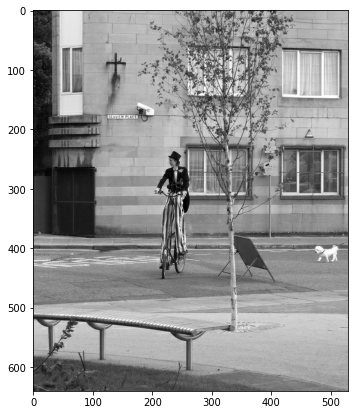

area:702.1057739257812
Image shape: (640, 529, 3)


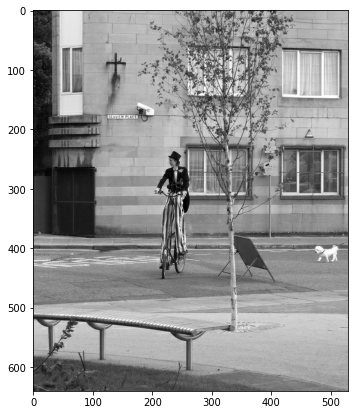

category_id:18
Image shape: (640, 529, 3)


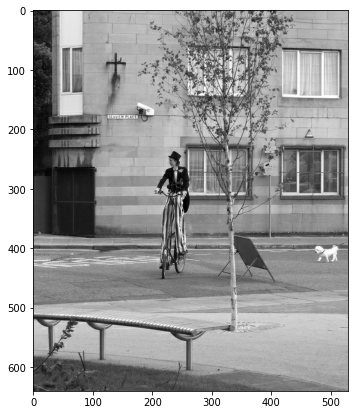

id:1768
Image shape: (640, 529, 3)


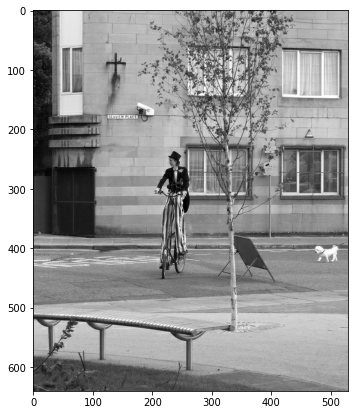

Image shape: (640, 529, 3)


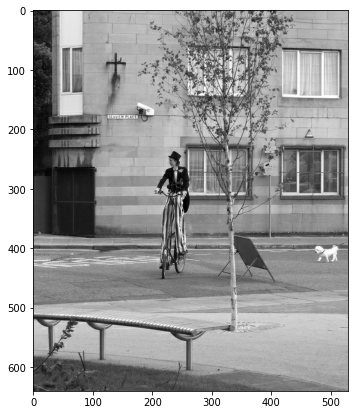

image_id:289343
Image shape: (640, 529, 3)


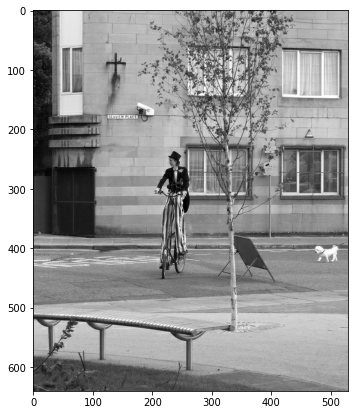

path:b'datasets\\val2017/000000289343.jpg'
Image shape: (640, 529, 3)


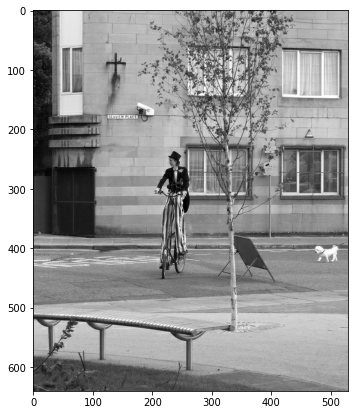

In [22]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}:{features[key]}")
        print(f"Image shape: {features['image'].shape}")
        plt.figure(figsize=(7, 7))
        plt.imshow(features["image"].numpy())
        plt.show()

In [25]:
def prepare_sample(features):
    image = tf.image.resize(features["image"], size=(224, 224))
    return image, features["category_id"]

def get_dataset(filenames, batch_size):
    dataset = (tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
              .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
              .map(prepare_sample, num_parallel_calls=AUTOTUNE)
              .shuffle(batch_size * 10)
              .batch(batch_size)
              .prefetch(AUTOTUNE))
    return dataset
train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
batch_size = 32
epochs = 1
steps_per_epoch = 50
AUTOTUNE = tf.data.AUTOTUNE

input_tensor = tf.keras.layers.Input(shape=(224, 224, 3), name="image")
model = tf.keras.applications.EfficientNetB0(input_tensor=input_tensor, weights=None, classes=91)
model.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
             metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(x=get_dataset(train_filenames, batch_size), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)

50/50 [==============================] - 352s 7s/step - loss: 3.6728 - sparse_categorical_accuracy: 0.1819


# Project 84

In [27]:
import tensorflow as tf
from tensorflow.keras import layers

class MyAntirectifier(layers.Layer):
    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(output_dim * 2, output_dim), initializer="he_normal", name="kernel",
                                     trainable=True)
    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        concatenated = tf.concat([pos, neg], axis=0)
        return tf.matmul(concatenated, self.kernel)

In [28]:
x = tf.random.normal(shape=(2, 5))
y = MyAntirectifier()(x)

InvalidArgumentError: Exception encountered when calling layer "my_antirectifier" (type MyAntirectifier).

Matrix size-incompatible: In[0]: [4,5], In[1]: [10,5] [Op:MatMul]

Call arguments received:
  • inputs=tf.Tensor(shape=(2, 5), dtype=float32)

In [29]:
class Myrectifier(layers.Layer):
    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(output_dim * 2, output_dim), initializer="he_normal", name="kernel", 
                                      trainable=True)
    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        print("pos.shape", pos.shape)
        print("neg.shape", neg.shape)
        concatenated = tf.concat([pos, neg], axis=0)
        print("concatenated.shape", concatenated.shape)
        print("kernel.shape", self.kernel.shape)
        return tf.matmul(concatenated, self.kernel)

In [30]:
class MyAntirectifier(layers.Layer):
    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(output_dim * 2, output_dim), 
                                     initializer = "he_normal", name="kernel", trainable=True)
    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        print("pos.shape", pos.shape)
        print("neg.shape", neg.shape)
        concatenated = tf.concat([pos, neg], axis=1)
        print("concatenated.shape", concatenated.shape)
        print("kernel.shape", self.kernel.shape)
        return tf.matmul(concatenated, self.kernel)

In [31]:
x = tf.random.normal((2, 5))
y = MyAntirectifier()(x)

pos.shape (2, 5)
neg.shape (2, 5)
concatenated.shape (2, 10)
kernel.shape (10, 5)


In [33]:
from tensorflow import keras
num_tags = 12
num_words = 10000
num_departments = 4
title_input = keras.Input(shape=(None, ), name="title")
body_input = keras.Input(shape=(None, ), name="body")
tags_input = keras.Input(shape=(num_tags, ), name="tags")
title_features = layers.Embedding(num_words, 64)(title_input)
body_features = layers.Embedding(num_words, 64)(body_input)
title_features = layers.LSTM(128)(title_features)
body_features = layers.LSTM(32)(body_features)
x = layers.concatenate([title_features, body_features, tags_input])
priority_pred = layers.Dense(1, name="priority")(x)
department_pred = layers.Dense(num_departments, name="department")(x)
model = keras.Model(inputs=[title_input, body_input, tags_input], outputs = [priority_pred, department_pred])

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 body (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     640000      ['title[0][0]']                  
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     640000      ['body[0][0]']                   
                                                                                              

In [35]:
class MyModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        trainable_vars = self.trainable_variables
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:
                preds = self(inputs, training=True)  # Forward pass
                # Compute the loss value
                # (the loss function is configured in `compile()`)
                loss = self.compiled_loss(targets, preds)
            # Compute first-order gradients
            dl_dw = tape1.gradient(loss, trainable_vars)
        # Compute second-order gradients
        d2l_dw2 = tape2.gradient(dl_dw, trainable_vars)

        # Combine first-order and second-order gradients
        grads = [0.5 * w1 + 0.5 * w2 for (w1, w2) in zip(d2l_dw2, dl_dw)]

        # Update weights
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(targets, preds)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


In [36]:
import numpy as np
def get_model():
    inputs = keras.Input(shape=(784,))
    intermediate = layers.Dense(256, activation="relu")(inputs)
    outputs = layers.Dense(10, activation="softmax")(intermediate)
    model = MyModel(inputs, outputs)
    return model

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784)) / 255
model = get_model()
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2), 
             loss="sparse_categorical_crossentropy", 
             metrics=["accuracy"])
model.fit(x_train, y_train, epochs=3, batch_size=1024, validation_split=0.1)

Epoch 1/3
53/53 [==============================] - 2s 24ms/step - loss: 2.3007 - accuracy: 0.1596 - val_loss: 2.2996 - val_accuracy: 0.1073
Epoch 2/3
53/53 [==============================] - 1s 23ms/step - loss: 2.3123 - accuracy: 0.0992 - val_loss: 2.3227 - val_accuracy: 0.0995
Epoch 3/3
53/53 [==============================] - 1s 21ms/step - loss: 2.3317 - accuracy: 0.0974 - val_loss: 2.3405 - val_accuracy: 0.0995


In [37]:
class MyModel(keras.Model):
    def train_step(self, data):
        print()
        print("----Start of step: %d" % (self.step_counter,))
        self.step_counter += 1

        inputs, targets = data
        trainable_vars = self.trainable_variables
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:
                preds = self(inputs, training=True)  # Forward pass
                # Compute the loss value
                # (the loss function is configured in `compile()`)
                loss = self.compiled_loss(targets, preds)
            # Compute first-order gradients
            dl_dw = tape1.gradient(loss, trainable_vars)
        # Compute second-order gradients
        d2l_dw2 = tape2.gradient(dl_dw, trainable_vars)

        print("Max of dl_dw[0]: %.4f" % tf.reduce_max(dl_dw[0]))
        print("Min of dl_dw[0]: %.4f" % tf.reduce_min(dl_dw[0]))
        print("Mean of dl_dw[0]: %.4f" % tf.reduce_mean(dl_dw[0]))
        print("-")
        print("Max of d2l_dw2[0]: %.4f" % tf.reduce_max(d2l_dw2[0]))
        print("Min of d2l_dw2[0]: %.4f" % tf.reduce_min(d2l_dw2[0]))
        print("Mean of d2l_dw2[0]: %.4f" % tf.reduce_mean(d2l_dw2[0]))

        # Combine first-order and second-order gradients
        grads = [0.5 * w1 + 0.5 * w2 for (w1, w2) in zip(d2l_dw2, dl_dw)]

        # Update weights
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(targets, preds)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


model = get_model()
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-2),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    run_eagerly=True,
)
model.step_counter = 0
# We pass epochs=1 and steps_per_epoch=10 to only run 10 steps of training.
model.fit(x_train, y_train, epochs=1, batch_size=1024, verbose=0, steps_per_epoch=10)



----Start of step: 0
Max of dl_dw[0]: 0.0291
Min of dl_dw[0]: -0.0219
Mean of dl_dw[0]: 0.0001
-
Max of d2l_dw2[0]: 2.3421
Min of d2l_dw2[0]: -2.5984
Mean of d2l_dw2[0]: 0.0464

----Start of step: 1
Max of dl_dw[0]: 0.0624
Min of dl_dw[0]: -0.0239
Mean of dl_dw[0]: 0.0010
-
Max of d2l_dw2[0]: 5.6660
Min of d2l_dw2[0]: -2.9467
Mean of d2l_dw2[0]: 0.1123

----Start of step: 2
Max of dl_dw[0]: 0.0560
Min of dl_dw[0]: -0.0143
Mean of dl_dw[0]: 0.0010
-
Max of d2l_dw2[0]: 4.4854
Min of d2l_dw2[0]: -1.5548
Mean of d2l_dw2[0]: 0.1025

----Start of step: 3
Max of dl_dw[0]: 0.0347
Min of dl_dw[0]: -0.0145
Mean of dl_dw[0]: 0.0002
-
Max of d2l_dw2[0]: 5.6690
Min of d2l_dw2[0]: -0.3912
Mean of d2l_dw2[0]: 0.1309

----Start of step: 4
Max of dl_dw[0]: 0.0040
Min of dl_dw[0]: -0.0070
Mean of dl_dw[0]: -0.0001
-
Max of d2l_dw2[0]: 0.4864
Min of d2l_dw2[0]: -0.0398
Mean of d2l_dw2[0]: 0.0100

----Start of step: 5
Max of dl_dw[0]: 0.0041
Min of dl_dw[0]: -0.0064
Mean of dl_dw[0]: -0.0001
-
Max of d2l

In [38]:
class MyModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        trainable_vars = self.trainable_variables
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:
                preds = self(inputs, training=True)  # Forward pass
                # Compute the loss value
                # (the loss function is configured in `compile()`)
                loss = self.compiled_loss(targets, preds)
            # Compute first-order gradients
            dl_dw = tape1.gradient(loss, trainable_vars)
        # Compute second-order gradients
        d2l_dw2 = tape2.gradient(dl_dw, trainable_vars)

        dl_dw = [tf.math.l2_normalize(w) for w in dl_dw]
        d2l_dw2 = [tf.math.l2_normalize(w) for w in d2l_dw2]

        # Combine first-order and second-order gradients
        grads = [0.5 * w1 + 0.5 * w2 for (w1, w2) in zip(d2l_dw2, dl_dw)]

        # Update weights
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(targets, preds)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


model = get_model()
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-2),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(x_train, y_train, epochs=5, batch_size=1024, validation_split=0.1)


Epoch 1/5
53/53 [==============================] - 2s 24ms/step - loss: 2.1530 - accuracy: 0.2616 - val_loss: 1.9837 - val_accuracy: 0.4413
Epoch 2/5
53/53 [==============================] - 1s 22ms/step - loss: 1.8849 - accuracy: 0.5166 - val_loss: 1.7570 - val_accuracy: 0.6050
Epoch 3/5
53/53 [==============================] - 1s 23ms/step - loss: 1.6920 - accuracy: 0.6156 - val_loss: 1.5844 - val_accuracy: 0.6683
Epoch 4/5
53/53 [==============================] - 1s 22ms/step - loss: 1.5534 - accuracy: 0.6449 - val_loss: 1.4642 - val_accuracy: 0.6880
Epoch 5/5
53/53 [==============================] - 1s 21ms/step - loss: 1.4589 - accuracy: 0.6471 - val_loss: 1.3826 - val_accuracy: 0.6868


In [39]:
class MyModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        trainable_vars = self.trainable_variables
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape1:
                preds = self(inputs, training=True)  # Forward pass
                # Compute the loss value
                # (the loss function is configured in `compile()`)
                loss = self.compiled_loss(targets, preds)
            # Compute first-order gradients
            dl_dw = tape1.gradient(loss, trainable_vars)
        # Compute second-order gradients
        d2l_dw2 = tape2.gradient(dl_dw, trainable_vars)

        dl_dw = [tf.math.l2_normalize(w) for w in dl_dw]
        d2l_dw2 = [tf.math.l2_normalize(w) for w in d2l_dw2]

        # Combine first-order and second-order gradients
        grads = [0.2 * w1 + 0.8 * w2 for (w1, w2) in zip(d2l_dw2, dl_dw)]

        # Update weights
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(targets, preds)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


model = get_model()
lr = learning_rate = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.1, decay_steps=25, decay_rate=0.1
)
model.compile(
    optimizer=keras.optimizers.SGD(lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(x_train, y_train, epochs=50, batch_size=2048, validation_split=0.1)


Epoch 1/50
27/27 [==============================] - 1s 37ms/step - loss: 1.3534 - accuracy: 0.6782 - val_loss: 0.6571 - val_accuracy: 0.8537
Epoch 2/50
27/27 [==============================] - 1s 32ms/step - loss: 0.5807 - accuracy: 0.8552 - val_loss: 0.3981 - val_accuracy: 0.9078
Epoch 3/50
27/27 [==============================] - 1s 34ms/step - loss: 0.4339 - accuracy: 0.8825 - val_loss: 0.3248 - val_accuracy: 0.9157
Epoch 4/50
27/27 [==============================] - 1s 32ms/step - loss: 0.3744 - accuracy: 0.8955 - val_loss: 0.2932 - val_accuracy: 0.9223
Epoch 5/50
27/27 [==============================] - 1s 33ms/step - loss: 0.3400 - accuracy: 0.9038 - val_loss: 0.2717 - val_accuracy: 0.9262
Epoch 6/50
27/27 [==============================] - 1s 35ms/step - loss: 0.3161 - accuracy: 0.9103 - val_loss: 0.2509 - val_accuracy: 0.9327
Epoch 7/50
27/27 [==============================] - 1s 33ms/step - loss: 0.2981 - accuracy: 0.9163 - val_loss: 0.2402 - val_accuracy: 0.9335
Epoch 8/50
27

# Project 85

In [40]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [43]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")
    def call(self, logits, targets=None, sample_weight=None):
        if targets is not None:
            loss = self.loss_fn(targets, logits, sample_weight)
            self.add_loss(loss)
            self.add_metric(self.accuracy_fn(targets, logits, sample_weight))
        return tf.nn.softmax(logits)

inputs = keras.Input((764, ), name="inputs")
logits = keras.layers.Dense(1)(inputs)
targets = keras.Input((1, ), name="targets")
sample_weight = keras.Input((1, ), name="sample_weight")
preds = LogisticEndpoint()(logits, targets, sample_weight)
model = keras.Model([inputs, targets, sample_weight], preds)

data = {
    "inputs":np.random.random((1000, 764)),
    "targets":np.random.random((1000, 1)),
    "sample_weight":np.random.random((1000, 1)),
}
model.compile(keras.optimizers.Adam(1e-3))
model.fit(data, epochs=2)

Epoch 1/2
32/32 [==============================] - 1s 5ms/step - loss: 0.3716 - accuracy: 0.0000e+00
Epoch 2/2
32/32 [==============================] - 0s 6ms/step - loss: 0.3596 - accuracy: 0.0000e+00


In [44]:
inputs = keras.Input((764, ), name="inputs")
logits = keras.layers.Dense(1)(inputs)
preds = LogisticEndpoint()(logits, targets=None, sample_weight=None)
inference_model = keras.Model(inputs, preds)
inference_model.set_weights(model.get_weights())
preds = inference_model.predict(np.random.random((1000, 764)))

In [47]:
class LogReg(keras.Model):
    def __init__(self):
        super(LogReg, self).__init__()
        self.dense = keras.layers.Dense(1)
        self.logistic_endpoint = LogisticEndpoint()
    def call(self, inputs):
        logits = self.dense(inputs["inputs"])
        preds = self.logistic_endpoint(logits=logits, targets=inputs["targets"], 
                                        sample_weight=inputs["sample_weight"])
        return preds
model = LogReg()
data = {
    "inputs":np.random.random((1000, 764)),
    "targets":np.random.random((1000, 1)),
    "sample_weight":np.random.random((1000, 1))
}
model.compile(keras.optimizers.Adam(1e-3))
model.fit(data, epochs=2)

Epoch 1/2
32/32 [==============================] - 1s 3ms/step - loss: 0.3548 - accuracy: 0.0000e+00
Epoch 2/2
32/32 [==============================] - 0s 4ms/step - loss: 0.3523 - accuracy: 0.0000e+00


# Project 86

In [48]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt

In [49]:
ratings_data = pd.read_csv("D:/datasets_CSV/ml-1m/ratings.dat", sep="::", names=["user_id", "movie_id", "rating", 
                                                                                "unix_timestamp"])
ratings_data["movie_id"] = ratings_data["movie_id"].apply(lambda x: f"movie_{x}")
ratings_data["user_id"] = ratings_data["user_id"].apply(lambda x: f"user_{x}")
ratings_data["rating"] = ratings_data["rating"].apply(lambda x: float(x))
del ratings_data["unix_timestamp"]

print(f"Number of users: {len(ratings_data.user_id.unique())}")
print(f"Number of movies: {len(ratings_data.movie_id.unique())}")
print(f"Number of ratings: {len(ratings_data.index)}")

<ipython-input-49-91a37239d8cd>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_data = pd.read_csv("D:/datasets_CSV/ml-1m/ratings.dat", sep="::", names=["user_id", "movie_id", "rating",


Number of users: 6040
Number of movies: 3706
Number of ratings: 1000209


In [51]:
random_selection = np.random.rand(len(ratings_data.index)) <= 0.85
train_data = ratings_data[random_selection]
eval_data = ratings_data[~random_selection]
train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
eval_data.to_csv("eval_data.csv", index=False, sep="|", header=False)
print(f"Train data split: {len(train_data.index)}")
print(f"eval data split: {len(eval_data.index)}")
print("Train and eval data files are saved")

Train data split: 850707
eval data split: 149502
Train and eval data files are saved


In [52]:
csv_header = list(ratings_data.columns)
user_vocabulary = list(ratings_data.user_id.unique())
movie_vocabulary = list(ratings_data.movie_id.unique())
target_feature_name = "rating"
learning_rate = 0.001
batch_size = 128
num_epochs = 3
base_embedding_dim = 64

In [60]:
def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=True):
    return tf.data.experimental.make_csv_dataset(csv_file_path, batch_size=batch_size, column_names=csv_header, 
                                                label_name=target_feature_name, num_epochs=1, header=False, 
                                                field_delim="|", shuffle=shuffle)
def run_experiment(model):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
    train_dataset = get_dataset_from_csv("train_data.csv", batch_size)
    eval_dataset = get_dataset_from_csv("eval_data.csv", batch_size, shuffle=False)
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=eval_dataset)
    return history

In [61]:
def embedding_encoder(vocabulary, embedding_dim, num_oov_indices=0, name=None):
    return keras.Sequential([
        StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=num_oov_indices),
        layers.Embedding(input_dim=len(vocabulary) + num_oov_indices, output_dim=embedding_dim)
    ], name=f"{name}_embedding" if name else None)

In [62]:
def create_baseline_model():
    user_input = layers.Input(name="user_id", shape=(), dtype=tf.string)
    user_embedding = embedding_encoder(vocabulary=user_vocabulary, embedding_dim=base_embedding_dim, 
                                       name="user")(user_input)
    movie_input = layers.Input(name="movie_id", shape=(), dtype=tf.string)
    movie_embedding = embedding_encoder(vocabulary=movie_vocabulary, embedding_dim=base_embedding_dim, 
                                        name="movie")(movie_input)
    logits = layers.Dot(axes=1, name="dot_similarity")([user_embedding, movie_embedding])
    prediction = keras.activations.sigmoid(logits) * 5
    model = keras.Model(inputs=[user_input, movie_input], outputs=prediction, name="baseline_model")
    return model
baseline_model = create_baseline_model()
baseline_model.summary()

Model: "baseline_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 user_embedding (Sequential)    (None, 64)           386560      ['user_id[0][0]']                
                                                                                                  
 movie_embedding (Sequential)   (None, 64)           237184      ['movie_id[0][0]']               
                                                                                     

Epoch 1/3
6647/6647 [==============================] - 285s 43ms/step - loss: 1.1498 - mae: 0.8626 - val_loss: 0.9382 - val_mae: 0.7588
Epoch 2/3
6647/6647 [==============================] - 284s 43ms/step - loss: 0.8181 - mae: 0.7141 - val_loss: 0.7947 - val_mae: 0.7058
Epoch 3/3
6647/6647 [==============================] - 279s 42ms/step - loss: 0.7320 - mae: 0.6748 - val_loss: 0.7527 - val_mae: 0.6851


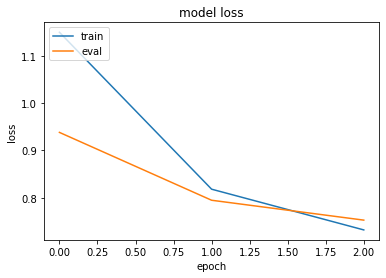

In [63]:
history = run_experiment(baseline_model)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()

In [76]:
class QREmbedding(keras.layers.Layer):
    def __init__(self, vocabulary, embedding_dim, num_buckets, name=None):
        super(QREmbedding, self).__init__(name=name)
        self.num_buckets = num_buckets
        self.index_lookup = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)
        self.q_embeddings = layers.Embedding(num_buckets, embedding_dim)
        self.r_embeddings = layers.Embedding(num_buckets, embedding_dim)
    def call(self, inputs):
        embedding_index = self.index_lookup(inputs)
        quotient_index = tf.math.floordiv(embedding_index, self.num_buckets)
        remainder_index = tf.math.floormod(embedding_index, self.num_buckets)
        quotient_embedding = self.q_embeddings(quotient_index)
        remainder_embedding = self.r_embeddings(remainder_index)
        return quotient_embedding * remainder_embedding

In [86]:
class MDEmbedding(keras.layers.Layer):
    def __init__(self, blocks_vocabulary, blocks_embedding_dims, base_embedding_dim, name=None):
        super(MDEmbedding, self).__init__(name=name)
        self.num_blocks = len(blocks_vocabulary)
        keys = []
        values = []
        for block_idx, block_vocab in enumerate(blocks_vocabulary):
            keys.extend(block_vocab)
            values.extend([block_idx] * len(block_vocab))
        self.vocab_to_block = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys, values),
                                                        default_value=-1)
        self.block_embedding_encoders = []
        self.block_embedding_projectors = []
        
        for idx in range(self.num_blocks):
            vocabulary = blocks_vocabulary[idx]
            embedding_dim = blocks_embedding_dims[idx]
            block_embedding_encoder = embedding_encoder(vocabulary, embedding_dim, num_oov_indices=1)
            self.block_embedding_encoders.append(block_embedding_encoder)
            if embedding_dim == base_embedding_dim:
                self.block_embedding_projectors.append(layers.Lambda(lambda x: x))
            else:
                self.block_embedding_projectors.append(layers.Dense(units=base_embedding_dim))
    def call(self, inputs):
        block_indices = self.vocab_to_block.lookup(inputs)
        embeddings = tf.zeros(shape=(tf.shape(inputs)[0], base_embedding_dim))
        for idx in range(self.num_blocks):
            block_embeddings = self.block_embedding_encoders[idx](inputs)
            block_embeddings = self.block_embedding_projectors[idx](block_embeddings)
            mask = tf.expand_dims(tf.cast(block_indices == idx, tf.dtypes.float32), 1)
            block_embeddings = block_embeddings * mask
            embeddings += block_embeddings
        return embeddings

<AxesSubplot:>

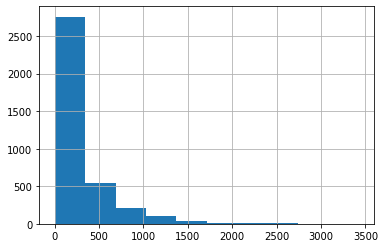

In [87]:
movie_frequencies = ratings_data["movie_id"].value_counts()
movie_frequencies.hist(bins=10)

In [88]:
sorted_movie_vocabulary = list(movie_frequencies.keys())
movie_blocks_vocabulary = [
    sorted_movie_vocabulary[:400],
    sorted_movie_vocabulary[400:1700],
    sorted_movie_vocabulary[1700:],
]
movie_blocks_embedding_dims = [64, 32, 16]
user_embedding_num_buckets = len(user_vocabulary) // 50

def create_memory_efficient_model():
    user_input = layers.Input(name="user_id", shape=(), dtype=tf.string)
    user_embedding = QREmbedding(vocabulary=user_vocabulary, embedding_dim=base_embedding_dim, 
                                 num_buckets=user_embedding_num_buckets, name="user_embedding")(user_input)
    movie_input = layers.Input(name="movie_id", shape=(), dtype=tf.string)
    movie_embedding = MDEmbedding(blocks_vocabulary=movie_blocks_vocabulary, 
                                  blocks_embedding_dims=movie_blocks_embedding_dims, 
                                  base_embedding_dim=base_embedding_dim, name="movie_embeddig")(movie_input)
    logits = layers.Dot(axes=1, name="dot_similarity")([user_embedding, movie_embedding])
    prediction = keras.activations.sigmoid(logits) * 5
    model = keras.Model(inputs=[user_input, movie_input], outputs=prediction, name="baseline_model")
    return model
memory_efficient_model = create_memory_efficient_model()
memory_efficient_model.summary()

Model: "baseline_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 user_embedding (QREmbedding)   (None, 64)           15360       ['user_id[0][0]']                
                                                                                                  
 movie_embeddig (MDEmbedding)   (None, 64)           102608      ['movie_id[0][0]']               
                                                                                     

<AxesSubplot:>

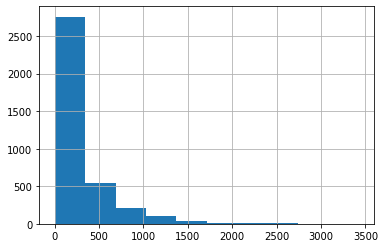

In [89]:
movie_frequencies = ratings_data["movie_id"].value_counts()
movie_frequencies.hist(bins=10)

In [91]:
sorted_movie_vocabulary = list(movie_frequencies.keys())
movie_blocks_vocabulary = [
    sorted_movie_vocabulary[:400],
    sorted_movie_vocabulary[400:1700],
    sorted_movie_vocabulary[1700:]
]
movie_blocks_embedding_dims = [64, 32, 16]
user_embedding_num_buckets = len(user_vocabulary) // 50

def create_memory_efficient_model():
    user_input = layers.Input(name="user_id", shape=(), dtype=tf.string)
    user_embedding = QREmbedding(vocabulary=user_vocabulary, embedding_dim=base_embedding_dim, 
                                num_buckets=user_embedding_num_buckets, name="user_embedding")(user_input)
    movie_input = layers.Input(name="movie_id", shape=(), dtype=tf.string)
    movie_embedding = MDEmbedding(blocks_vocabulary=movie_blocks_vocabulary, 
                                  blocks_embedding_dims=movie_blocks_embedding_dims, 
                                 base_embedding_dim=base_embedding_dim, 
                                 name="movie_embedding")(movie_input)
    logits = layers.Dot(axes=1, name="dot_similarity")([user_embedding, movie_embedding])
    prediction = keras.activations.sigmoid(logits) * 5
    model = keras.Model(inputs=[user_input, movie_input], outputs=prediction, name="baseline_model")
    return model
memory_efficient_model = create_memory_efficient_model()
memory_efficient_model.summary()

Model: "baseline_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 user_embedding (QREmbedding)   (None, 64)           15360       ['user_id[0][0]']                
                                                                                                  
 movie_embedding (MDEmbedding)  (None, 64)           102608      ['movie_id[0][0]']               
                                                                                     

In [92]:
history = run_experiment(memory_efficient_model)

Epoch 1/3
6647/6647 [==============================] - 203s 30ms/step - loss: 1.0313 - mae: 0.8134 - val_loss: 1.0820 - val_mae: 0.8105
Epoch 2/3
6647/6647 [==============================] - 201s 30ms/step - loss: 0.8803 - mae: 0.7455 - val_loss: 0.8936 - val_mae: 0.7511
Epoch 3/3
6647/6647 [==============================] - 201s 30ms/step - loss: 0.8351 - mae: 0.7245 - val_loss: 0.8618 - val_mae: 0.7357


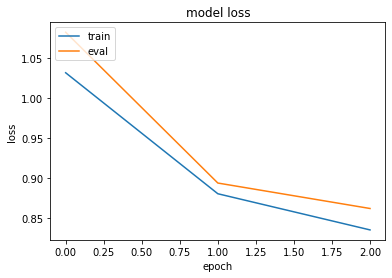

In [93]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()

# Project 87

In [94]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures

In [96]:
model = keras.Sequential([
    keras.Input(shape=(784, )), 
    RandomFourierFeatures(output_dim=4096, scale=10.0, kernel_initializer="gaussian"),
    layers.Dense(units=10)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
             loss=keras.losses.hinge, 
             metrics=[keras.metrics.CategoricalAccuracy(name="acc")])

In [97]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 784).astype("float32")/255
x_test = x_test.reshape(-1, 784).astype("float32")/255

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [99]:
model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 14s 34ms/step - loss: 0.0829 - acc: 0.8636 - val_loss: 0.0431 - val_acc: 0.9347
Epoch 2/20
375/375 [==============================] - 13s 33ms/step - loss: 0.0420 - acc: 0.9361 - val_loss: 0.0352 - val_acc: 0.9491
Epoch 3/20
375/375 [==============================] - 13s 34ms/step - loss: 0.0330 - acc: 0.9515 - val_loss: 0.0329 - val_acc: 0.9558
Epoch 4/20
375/375 [==============================] - 13s 33ms/step - loss: 0.0286 - acc: 0.9587 - val_loss: 0.0303 - val_acc: 0.9554
Epoch 5/20
375/375 [==============================] - 12s 33ms/step - loss: 0.0253 - acc: 0.9638 - val_loss: 0.0298 - val_acc: 0.9570
Epoch 6/20
375/375 [==============================] - 12s 33ms/step - loss: 0.0231 - acc: 0.9688 - val_loss: 0.0255 - val_acc: 0.9634
Epoch 7/20
375/375 [==============================] - 13s 33ms/step - loss: 0.0212 - acc: 0.9711 - val_loss: 0.0234 - val_acc: 0.9673
Epoch 8/20
375/375 [==============================] - 12s 33ms

# Project 88

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
AUTO = tf.data.AUTOTUNE

In [102]:
dataset_name = "tf_flowers"
batch_size = 64
image_size = (224, 224)
(train_data, test_data), ds_info = tfds.load(dataset_name, split=["train[:90%]", "train[90%:]"], 
                                             shuffle_files=True, as_supervised=True, with_info=True)
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

def dataset_to_array(dataset, image_size, num_classes):
    images, labels = [], []
    for img, lab in dataset.as_numpy_iterator():
        images.append(tf.image.resize(img, image_size).numpy())
        labels.append(tf.one_hot(lab, num_classes))
    return np.array(images), np.array(labels)

img_train, label_train = dataset_to_array(train_data, image_size, num_classes)
img_test, label_test = dataset_to_array(test_data, image_size, num_classes)

num_train_samples = len(img_train)
print(f"Number of training samples: {num_train_samples}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to C:\Users\jatin\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.
Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of training samples: 3303


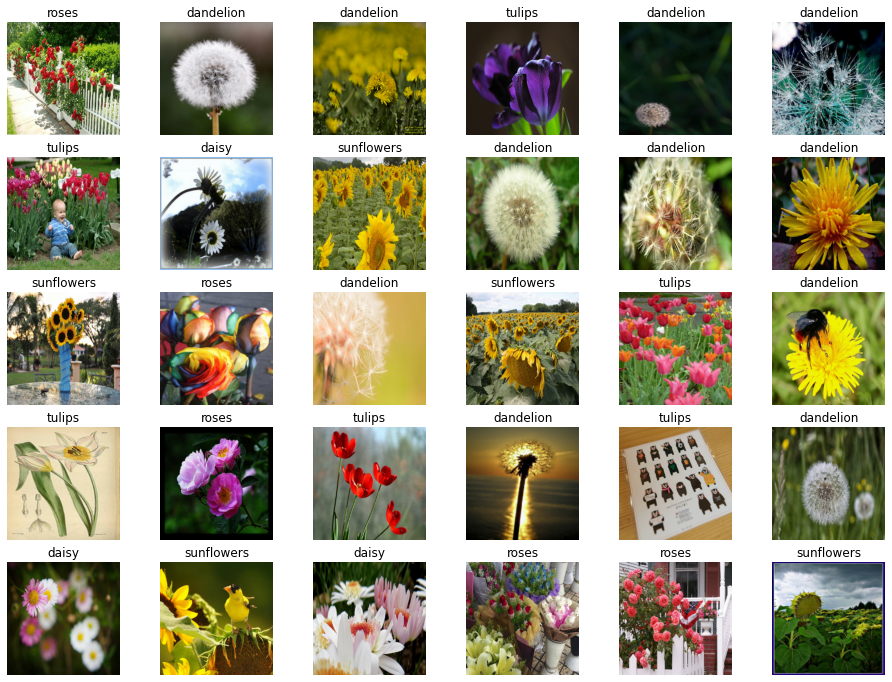

In [103]:
plt.figure(figsize = (16, 12))
for n in range(30):
    ax = plt.subplot(5, 6, n+ 1)
    plt.imshow(img_test[n].astype("uint8"))
    plt.title(np.array(class_names)[label_test[n] == True][0])
    plt.axis("off")

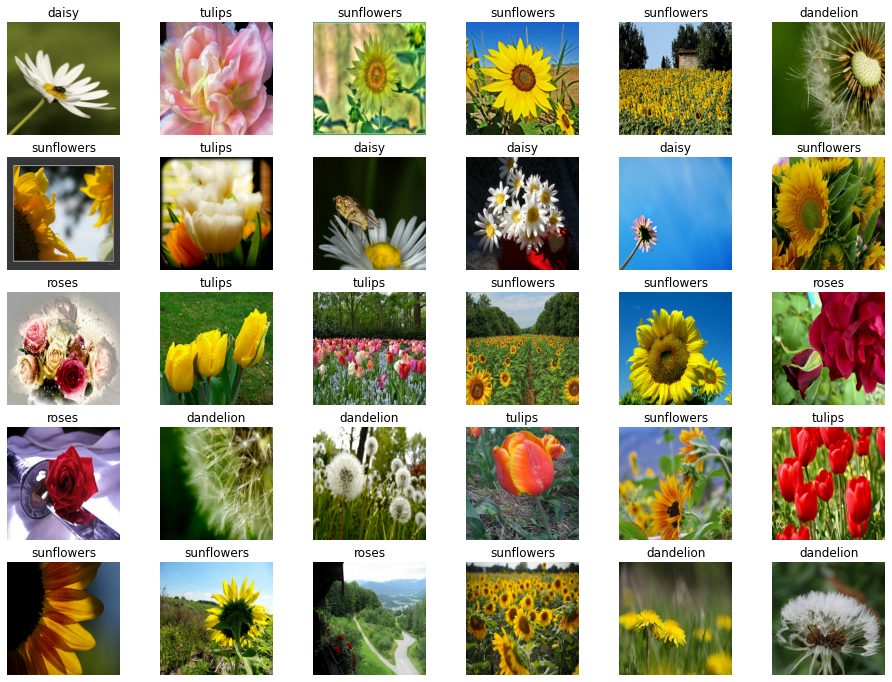

In [104]:
image_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=(-0.1, -0)),
    layers.RandomContrast(factor=0.1)
])

img_train = image_augmentation(img_train).numpy()
plt.figure(figsize=(16, 12))
for n in range(30):
    ax = plt.subplot(5, 6, n + 1)
    plt.imshow(img_train[n].astype("uint8"))
    plt.title(np.array(class_names)[label_train[n] == True][0])
    plt.axis("off")

In [116]:
def build_model(num_classes, img_size=image_size[0], top_dropout=0.3):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    model = keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)
    model.trainable=False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Dropout(top_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    
    print("Trainable weights:", len(model.trainable_weights))
    print("Non_trainable weights:", len(model.non_trainable_weights))
    return model

def compile_and_train(model, training_data, training_labels, metrics=[keras.metrics.AUC(name="auc"), "acc"], 
                     optimizer = keras.optimizers.Adam(), patience=5, epochs=5):
    stopper = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", min_delta=0, patience=patience, 
                                           verbose=1, restore_best_weights=True)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics)
    history = model.fit(x=training_data, y=training_labels, batch_size=batch_size, epochs=epochs, 
                        validation_split=0.1, callbacks=[stopper])
    return history

def unfreeze(model, block_name, verbose=0):
    set_trainable = False
    for layer in model.layers:
        if block_name in layer.name:
            set_trainable = True
        if set_trainable and not isinstance(layers.BatchNormalization):
            layer.trainable = True
            if verbose == 1:
                print(layer.name, "trianable")
        else:
            if verbose == 1:
                print(layer.name, "NOT trainable")
                
    print("trainable weights:", len(model.trainable_weights))
    print("Non-trainable weights:", len(model.non_trainable_weights))
    return model

In [117]:
def train_model(training_data, training_labels):
    model = build_model(num_classes)
    history = compile_and_train(model, training_data, training_labels, metrics=[keras.metrics.AUC(name="auc"), 
                                                                               "acc"], patience=3, epochs=10)
    model = unfreeze(model, "block_10")
    fine_tune_epochs = 20
    total_epochs = history.epoch[-1] + fine_tune_epochs
    history_fine = compile_and_train(model, training_data, training_labels, 
                                     metrics=[keras.metrics.AUC(name="auc"), "acc"], 
                                    optimizer=keras.optimizers.Adam(learning_rate=1e-4), patience=5, 
                                     epochs=total_epochs)
    _, _, acc = model.evaluate(ing_test, label_test)
    return np.round(acc, 4)

In [113]:
def train_iteratively(sample_splits=[0.05, 0.1, 0.25, 0.5], iter_per_split=5):
    train_acc = []
    sample_sizes = []
    for fraction in sample_splits:
        print(f"Fraction split: {fraction}")
        sample_accuracy = []
        num_samples = int(num_train_samples * fraction)
        for i in range(iter_per_split):
            print(f"Run {i + 1} out of {iter_per_split}:")
            rand_idx = np.random.randint(num_train_samples, size=num_samples)
            train_img_subset = img_train[rand_idx, :]
            train_label_subset = label_train[rand_idx, :]
            
            accuracy = train_model(train_img_subset, train_label_subset)
            print(f"Accuracy: {accuracy}")
            sample_accuracy.append(accuracy)
        train_acc.append(sample_accuracy)
        sample_sizes.append(num_samples)
    return train_acc, sample_sizes

train_acc = [
    [0.8202, 0.7466, 0.8011, 0.8447, 0.8229],
    [0.861, 0.8774, 0.8501, 0.8937, 0.891],
    [0.891, 0.9237, 0.8856, 0.9101, 0.891],
    [0.8937, 0.9373, 0.9128, 0.8719, 0.9128],
]

sample_sizes = [165, 330, 825, 1651]

Curve fit weights: a = 0.4376485049724579 and b = 0.10760075598955154
Amodel accuracy of 1.0465564727783203 is predicted for 3303 samples.


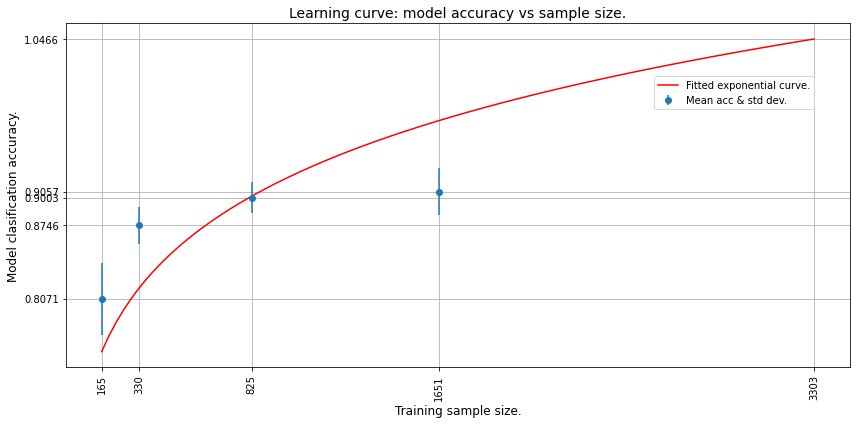

The mae for the curve fit is 0.04340037703514099.


In [114]:
def fit_and_predict(train_acc, sample_sizes, pred_sample_size):
    x = sample_sizes
    mean_acc = [np.mean(i) for i in train_acc]
    error = [np.std(i) for i in train_acc]
    mse = keras.losses.MeanSquaredError()
    
    def exp_func(x, a, b):
        return a * x ** b
    a = tf.Variable(0.0)
    b = tf.Variable(0.0)
    leanring_rate = 0.01
    training_epochs = 5000
    
    for epoch in range(training_epochs):
        with tf.GradientTape() as tape:
            y_pred = exp_func(x, a, b)
            cost_function = mse(y_pred, mean_acc)
        gradients = tape.gradient(cost_function, [a, b])
        a.assign_sub(gradients[0] * learning_rate)
        b.assign_sub(gradients[1] * learning_rate)
    print(f"Curve fit weights: a = {a.numpy()} and b = {b.numpy()}")
    max_acc = exp_func(pred_sample_size, a, b).numpy()
    print(f"Amodel accuracy of {max_acc} is predicted for {pred_sample_size} samples.")
    x_cont = np.linspace(x[0], pred_sample_size, 100)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.errorbar(x, mean_acc, yerr=error, fmt="o", label="Mean acc & std dev.")
    ax.plot(x_cont, exp_func(x_cont, a, b), "r-", label="Fitted exponential curve.")
    ax.set_ylabel("Model clasification accuracy.", fontsize=12)
    ax.set_xlabel("Training sample size.", fontsize=12)
    ax.set_xticks(np.append(x, pred_sample_size))
    ax.set_yticks(np.append(mean_acc, max_acc))
    ax.set_xticklabels(list(np.append(x, pred_sample_size)), rotation=90, fontsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_title("Learning curve: model accuracy vs sample size.", fontsize=14)
    ax.legend(loc=(0.75, 0.75), fontsize=10)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

    # The mean absolute error (MAE) is calculated for curve fit to see how well
    # it fits the data. The lower the error the better the fit.
    mae = keras.losses.MeanAbsoluteError()
    print(f"The mae for the curve fit is {mae(mean_acc, exp_func(x, a, b)).numpy()}.")


# We use the whole training set to predict the model accuracy
fit_and_predict(train_acc, sample_sizes, pred_sample_size=num_train_samples)

In [118]:
accuracy = train_model(img_train, label_train)
print(f"A model accuracy of {accuracy} is reached on {num_train_samples} images!")

Trainable weights: 2
Non_trainable weights: 260
Epoch 1/10
47/47 [==============================] - 81s 2s/step - loss: 1.0433 - auc: 0.8611 - acc: 0.5966 - val_loss: 0.5038 - val_auc: 0.9725 - val_acc: 0.8066
Epoch 2/10
47/47 [==============================] - 81s 2s/step - loss: 0.5351 - auc: 0.9640 - acc: 0.8112 - val_loss: 0.3795 - val_auc: 0.9843 - val_acc: 0.8610
Epoch 3/10
47/47 [==============================] - 80s 2s/step - loss: 0.4211 - auc: 0.9774 - acc: 0.8530 - val_loss: 0.3387 - val_auc: 0.9868 - val_acc: 0.8761
Epoch 4/10
47/47 [==============================] - 80s 2s/step - loss: 0.3699 - auc: 0.9826 - acc: 0.8758 - val_loss: 0.3028 - val_auc: 0.9899 - val_acc: 0.8882
Epoch 5/10
47/47 [==============================] - 80s 2s/step - loss: 0.3332 - auc: 0.9858 - acc: 0.8846 - val_loss: 0.2905 - val_auc: 0.9901 - val_acc: 0.8973
Epoch 6/10
47/47 [==============================] - 81s 2s/step - loss: 0.2985 - auc: 0.9887 - acc: 0.8950 - val_loss: 0.2972 - val_auc: 0.989

TypeError: isinstance expected 2 arguments, got 1

# Project 89

In [124]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.metrics import jaccard_score
import numpy as np
import os

class JaccardScoreCallback(keras.callbacks.Callback):
    def __init__(self, model, x_test, y_test, log_dir):
        self.model = model
        self.x_test = x_test
        self.y_test = y_test
        self.keras_metric = tf.keras.metrics.Mean("jaccard_score")
        self.epoch = 0
        self.summary_writer = tf.summary.create_file_writer(os.path.join(log_dir, model.name))
    def on_epoch_end(self, batch, logs=None):
        self.epoch += 1
        self.keras_metric.reset_state()
        predictions = self.model.predict(self.x_test)
        jaccard_value = jaccard_score(np.argmax(predictions, axis=-1), self.y_test, average=None)
        self.keras_metric.update_state(jaccard_value)
        self._write_metric(self.keras_metric.name, self.keras_metric.result().numpy().astype(float))
    def _write_metric(self, name, value):
        with self.summary_writer.as_default():
            tf.summary.scalar(name, value, step=self.epoch, )
            self.summary_writer.flush()

In [125]:
num_classes = 10
input_shape = (28, 28, 1)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test_samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])
model.summary()

batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
callbacks = [JaccardScoreCallback(model, x_test, np.argmax(y_test, axis=-1), "logs")]
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test_samples
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                              

# Project 90

In [126]:
import tensorflow.keras as keras
print(keras.__version__)

2.8.0


In [127]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import numpy as np

class StandardizedConv2DWithOverride(layers.Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(inputs, (kernel - mean) / tf.sqrt(var + 1e-10), padding="VALID", 
                            strides=list(self.strides), name=self.__class__.__name__)

In [128]:
class StandardizedConv2DWithCall(layers.Conv2D):
    def call(self, inputs):
        mean, var = tf.nn.moments(self.kernel, axes=[0, 1, 2], keepdims=True)
        result = self.convolution_op(inputs, (self.kernel - mean) / tf.sqrt(var + 1e-10))
        if self.use_bias:
            result = result + self.bias
        return result

In [132]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=input_shape),
        StandardizedConv2DWithCall(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        StandardizedConv2DWithOverride(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 standardized_conv2d_with_ca  (None, 26, 26, 32)       320       
 ll_1 (StandardizedConv2DWit                                     
 hCall)                                                          
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 standardized_conv2d_with_ov  (None, 11, 11, 64)       18496     
 erride_1 (StandardizedConv2                                     
 DWithOverride)                                                  
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)

In [133]:
batch_size = 128
epochs = 5
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=5, validation_split=0.1)

Epoch 1/5
422/422 [==============================] - 37s 84ms/step - loss: 1.8461 - accuracy: 0.8396 - val_loss: 0.1126 - val_accuracy: 0.9723
Epoch 2/5
422/422 [==============================] - 35s 82ms/step - loss: 0.2340 - accuracy: 0.9353 - val_loss: 0.0764 - val_accuracy: 0.9802
Epoch 3/5
422/422 [==============================] - 35s 82ms/step - loss: 0.1519 - accuracy: 0.9567 - val_loss: 0.0728 - val_accuracy: 0.9807
Epoch 4/5
422/422 [==============================] - 34s 82ms/step - loss: 0.1218 - accuracy: 0.9658 - val_loss: 0.0536 - val_accuracy: 0.9862
Epoch 5/5
422/422 [==============================] - 34s 81ms/step - loss: 0.1029 - accuracy: 0.9702 - val_loss: 0.0524 - val_accuracy: 0.9863


# Project 91

In [134]:
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np

In [135]:
tnp.experimental_enable_numpy_behavior()

In [139]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz"
                                                                                 , test_split=0.2, seed=113)

def evaluate_model(model: keras.Model):
    [loss, percent_error] = model.evaluate(x_test, y_test, verbose=0)
    print("Mean absolute percent error before training: ", percent_error)
    model.fit(x_train, y_train, epochs=200, verbose=0)
    [loss, percent_error] = model.evaluate(x_test, y_test, verbose=0)
    print("Mean absolute percent error after training:", percent_error)

In [140]:
class TNPForwardFeedRegressionNetwork(keras.Model):
    def __init__(self, blocks=None, **kwargs):
        super(TNPForwardFeedRegressionNetwork, self).__init__(**kwargs)
        if not isinstance(blocks, list):
            raise ValueError(f"blocks must be a list, got blocks={blocks}")
        self.blocks = blocks
        self.block_weights = None
        self.biases = None
    def build(self, input_shape):
        current_shape = input_shape[1]
        self.block_weights = []
        self.biases = []
        for i, block in enumerate(self.blocks):
            self.block_weights.append(self.add_weight(shape=(current_shape, block), trainable=True, 
                                                      name=f"block-{i}"))
            self.biases.append(self.add_weight(shape=(block, ), trainable=True, name=f"bias-{i}"))
            current_shape = block
        self.linear_layer = self.add_weight(shape=(current_shape, 1), name="linear_projector", trainable=True)
    def call(self, inputs):
        activations = inputs
        for w, b in zip(self.block_weights, self.biases):
            activations = tnp.matmul(activations, w) + b
            activations = tnp.maximum(activations, 0.0)
        return tnp.matmul(activations, self.linear_layer)

In [141]:
model = TNPForwardFeedRegressionNetwork(blocks=[3, 3])
model.compile(optimizer="adam", loss="mean_squared_error", metrics=[keras.metrics.MeanAbsolutePercentageError()])
evaluate_model(model)

Mean absolute percent error before training:  65.54676818847656
Mean absolute percent error after training: 28.48102378845215


In [143]:
def tnp_mse(y_true, y_pred):
    return tnp.mean(tnp.square(y_true - y_pred), axis=0)

keras.backend.clear_session()
model = TNPForwardFeedRegressionNetwork(blocks=[3, 3])
model.compile(optimizer="adam", loss=tnp_mse, metrics=[keras.metrics.MeanAbsolutePercentageError()])
evaluate_model(model)

Mean absolute percent error before training:  100.0
Mean absolute percent error after training: 100.0


In [147]:
def tnp_relu(x):
    return tnp.maximum(x, 0)


class TNPDense(keras.layers.Layer):
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        self.w = self.add_weight(
            name="weights",
            shape=(input_shape[1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.bias = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, inputs):
        outputs = tnp.matmul(inputs, self.w) + self.bias
        if self.activation:
            return self.activation(outputs)
        return outputs


def create_layered_tnp_model():
    return keras.Sequential(
        [
            TNPDense(3, activation=tnp_relu),
            TNPDense(3, activation=tnp_relu),
            TNPDense(1),
        ]
    )


model = create_layered_tnp_model()
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=[keras.metrics.MeanAbsolutePercentageError()],
)
model.build((None, 13,))
model.summary()

evaluate_model(model)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tnp_dense_3 (TNPDense)      (None, 3)                 42        
                                                                 
 tnp_dense_4 (TNPDense)      (None, 3)                 12        
                                                                 
 tnp_dense_5 (TNPDense)      (None, 1)                 4         
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
Mean absolute percent error before training:  99.9163589477539
Mean absolute percent error after training: 29.15201187133789


In [148]:
def create_mixed_model():
    return keras.Sequential([
        TNPDense(3, activation=tnp_relu),
        layers.Dense(3, activation="relu"),
        TNPDense(1)
    ])

model = create_mixed_model()
model.compile(optimizer="adam", loss="mean_squared_error", metrics=[keras.metrics.MeanAbsolutePercentageError()])
model.build((None, 13,))
evaluate_model(model)

Mean absolute percent error before training:  102.01209259033203
Mean absolute percent error after training: 24.1574764251709


In [150]:
models = [
    (TNPForwardFeedRegressionNetwork(blocks=[3, 3]), "TNPForwardFeedRegressionNetwork"),
    (create_layered_tnp_model(), "layered_tnp_model"),
    (create_mixed_model(), "mixed_model"),
]
for model, model_name in models:
    model.compile(optimizer="adam", loss="mean_squared_error", 
                  metrics=[keras.metrics.MeanAbsolutePercentageError()])
    model.fit(x_train, y_train, epochs=200)

Epoch 1/200
13/13 [==============================] - 1s 3ms/step - loss: 551.3618 - mean_absolute_percentage_error: 104.3782
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 407.1294 - mean_absolute_percentage_error: 83.8496
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 333.7415 - mean_absolute_percentage_error: 72.0330
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 272.5971 - mean_absolute_percentage_error: 64.5643
Epoch 5/200
13/13 [==============================] - 0s 5ms/step - loss: 234.7193 - mean_absolute_percentage_error: 59.7206
Epoch 6/200
13/13 [==============================] - 0s 4ms/step - loss: 202.4134 - mean_absolute_percentage_error: 55.5767
Epoch 7/200
13/13 [==============================] - 0s 4ms/step - loss: 177.3343 - mean_absolute_percentage_error: 52.2122
Epoch 8/200
13/13 [==============================] - 0s 4ms/step - loss: 157.7120 - mean_absolute_percentage_error: 49.8142
Epoch 9

13/13 [==============================] - 0s 2ms/step - loss: 54.6280 - mean_absolute_percentage_error: 26.3005
Epoch 68/200
13/13 [==============================] - 0s 3ms/step - loss: 54.2537 - mean_absolute_percentage_error: 25.9184
Epoch 69/200
13/13 [==============================] - 0s 3ms/step - loss: 54.2132 - mean_absolute_percentage_error: 26.0214
Epoch 70/200
13/13 [==============================] - 0s 3ms/step - loss: 54.0425 - mean_absolute_percentage_error: 25.6567
Epoch 71/200
13/13 [==============================] - 0s 4ms/step - loss: 54.3544 - mean_absolute_percentage_error: 26.3209
Epoch 72/200
13/13 [==============================] - 0s 4ms/step - loss: 53.6407 - mean_absolute_percentage_error: 25.8548
Epoch 73/200
13/13 [==============================] - 0s 5ms/step - loss: 53.6667 - mean_absolute_percentage_error: 25.0677
Epoch 74/200
13/13 [==============================] - 0s 4ms/step - loss: 53.4155 - mean_absolute_percentage_error: 25.4610
Epoch 75/200
13/13 [=

13/13 [==============================] - 0s 3ms/step - loss: 39.9513 - mean_absolute_percentage_error: 21.8471
Epoch 198/200
13/13 [==============================] - 0s 3ms/step - loss: 39.9451 - mean_absolute_percentage_error: 22.3738
Epoch 199/200
13/13 [==============================] - 0s 3ms/step - loss: 39.7159 - mean_absolute_percentage_error: 21.8350
Epoch 200/200
13/13 [==============================] - 0s 3ms/step - loss: 39.6817 - mean_absolute_percentage_error: 21.8682
Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 595.4496 - mean_absolute_percentage_error: 101.1029
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 588.7861 - mean_absolute_percentage_error: 100.3133
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 585.6157 - mean_absolute_percentage_error: 99.9353
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 584.8240 - mean_absolute_percentage_error: 99.8436
Epoch 5/200
13/1

13/13 [==============================] - 0s 3ms/step - loss: 517.0814 - mean_absolute_percentage_error: 91.5931
Epoch 128/200
13/13 [==============================] - 0s 3ms/step - loss: 516.5566 - mean_absolute_percentage_error: 91.5266
Epoch 129/200
13/13 [==============================] - 0s 3ms/step - loss: 516.0307 - mean_absolute_percentage_error: 91.4609
Epoch 130/200
13/13 [==============================] - 0s 3ms/step - loss: 515.5108 - mean_absolute_percentage_error: 91.3940
Epoch 131/200
13/13 [==============================] - 0s 3ms/step - loss: 514.9830 - mean_absolute_percentage_error: 91.3284
Epoch 132/200
13/13 [==============================] - 0s 3ms/step - loss: 514.4654 - mean_absolute_percentage_error: 91.2609
Epoch 133/200
13/13 [==============================] - 0s 3ms/step - loss: 513.9364 - mean_absolute_percentage_error: 91.1959
Epoch 134/200
13/13 [==============================] - 0s 3ms/step - loss: 513.4147 - mean_absolute_percentage_error: 91.1303
Epoch 

13/13 [==============================] - 0s 3ms/step - loss: 48.2775 - mean_absolute_percentage_error: 23.3654
Epoch 59/200
13/13 [==============================] - 0s 3ms/step - loss: 48.5445 - mean_absolute_percentage_error: 21.9255
Epoch 60/200
13/13 [==============================] - 0s 3ms/step - loss: 48.3895 - mean_absolute_percentage_error: 24.9681
Epoch 61/200
13/13 [==============================] - 0s 3ms/step - loss: 47.7273 - mean_absolute_percentage_error: 21.9425
Epoch 62/200
13/13 [==============================] - 0s 2ms/step - loss: 47.0351 - mean_absolute_percentage_error: 23.4631
Epoch 63/200
13/13 [==============================] - 0s 2ms/step - loss: 46.7558 - mean_absolute_percentage_error: 21.9961
Epoch 64/200
13/13 [==============================] - 0s 2ms/step - loss: 47.0541 - mean_absolute_percentage_error: 23.8644
Epoch 65/200
13/13 [==============================] - 0s 2ms/step - loss: 45.9693 - mean_absolute_percentage_error: 22.1934
Epoch 66/200
13/13 [=

Epoch 124/200
13/13 [==============================] - 0s 3ms/step - loss: 30.8706 - mean_absolute_percentage_error: 20.7516
Epoch 125/200
13/13 [==============================] - 0s 3ms/step - loss: 31.1239 - mean_absolute_percentage_error: 19.5062
Epoch 126/200
13/13 [==============================] - 0s 3ms/step - loss: 30.9853 - mean_absolute_percentage_error: 20.2250
Epoch 127/200
13/13 [==============================] - 0s 3ms/step - loss: 30.6984 - mean_absolute_percentage_error: 20.7865
Epoch 128/200
13/13 [==============================] - 0s 3ms/step - loss: 31.0276 - mean_absolute_percentage_error: 20.0226
Epoch 129/200
13/13 [==============================] - 0s 3ms/step - loss: 29.9367 - mean_absolute_percentage_error: 19.8863
Epoch 130/200
13/13 [==============================] - 0s 3ms/step - loss: 30.3288 - mean_absolute_percentage_error: 20.2005
Epoch 131/200
13/13 [==============================] - 0s 3ms/step - loss: 29.9247 - mean_absolute_percentage_error: 19.7201
